In [1]:
import sys, os
sys.path.insert(0, '/home/niell_lab/Documents/github/FreelyMovingEphys/')
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from projects.ephys.population import Population
from src.utils.path import find
from src.utils.auxiliary import flatten_series
from scipy.interpolate import interp1d
from scipy.stats import linregress

In [2]:
from src.utils.auxiliary import flatten_series
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
from projects.ephys.population import to_color

In [4]:
mpl.rcParams.update({'font.size': 8})
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [5]:
%matplotlib inline

# Load data

In [6]:
hffm_savepath = '/home/niell_lab/Desktop'
hffm = Population(savepath=hffm_savepath)
hffm.load(fname='hffm_042722_rc')

reading from /home/niell_lab/Desktop/hffm_042722_rc.pickle


In [7]:
# for ind in hffm.data.index.values:
#     p = hffm.data.loc[ind, 'original_session_path']
#     l = list(filter(None, p.split('/')))
#     n = '/{}'.format('/'.join(*[l[0:2]+['Mounts']+l[2:]]))
#     hffm.data.at[ind, 'original_session_path'] = n

In [8]:
# hffm.data['original_session_path']

In [9]:
# hffm.add_avalible_RcSn_psth()

In [10]:
# hffm.save(fname='hffm_042722_rc', savedir='/home/niell_lab/Desktop/')

In [11]:
# hffm['']

In [39]:
ltdk_savepath = '/home/niell_lab/Desktop'
ltdk = Population(savepath=ltdk_savepath)
ltdk.load(fname='ltdk_0411822_sdf')

reading from /home/niell_lab/Desktop/ltdk_0411822_sdf.pickle


In [13]:
# pdf = PdfPages('/home/niell_lab/Desktop/paperfigs_042022.pdf')

# New colormap

In [7]:
plasma_map = plt.cm.plasma(np.linspace(0,1,15))

In [8]:
cat_cmap = {
    'movement': plasma_map[12,:],
    'early': plasma_map[10,:],
    'late': plasma_map[8,:],
    'biphasic': plasma_map[5,:],
    'negative': plasma_map[2,:],
    'unresponsive': 'dimgrey'
}
colors = {
    'gaze': 'firebrick',
    'comp': 'mediumblue'
}

# for plots shoting continous scatter of 
# for STAs or anything like that: seismic
# cmap for continous plots sorted by peak time: coolwarm (it has grey betwen the tow calues and diverges symetriclly)

In [9]:
psth_bins = np.arange(-1,1.001,1/1000)

In [13]:
u151 = hffm.data.loc[151, 'FmLt_gazeshift_left_saccPSTH_dHead'].copy().astype(float)

In [14]:
np.save('/home/niell_lab/Desktop/u151_gazeshift.npy', u151)

# Fig 1

In [15]:
def normalize_psth(psth, raw_pref=None, grat=False, baseline_val=None):
    psth_wind = {
        'start_base': 850, # -150msec
        'zero': 1000, # 0msec
        'end_evok': 1250 # +250msec
    }
    if raw_pref is None:
        raw_pref = psth.copy()
    if grat is True:
        psth_wind = {
            'zero': 5,
            'end_evok': 14
        }
        baseline_val = psth[5]
    if baseline_val is not None:
        return (psth - baseline_val) / np.nanmax(raw_pref[psth_wind['zero']:psth_wind['end_evok']].astype(float))
    norm_psth = (psth - np.nanmean(psth[psth_wind['start_base']:psth_wind['zero']].astype(float))) / np.nanmax(raw_pref[psth_wind['zero']:psth_wind['end_evok']].astype(float))
    return norm_psth

In [16]:
for ind, row in hffm.data.iterrows():
    if row['pref_gazeshift_direction']=='L':
        pref_dir = 'left'
        nonpref_dir = 'right'
    elif row['pref_gazeshift_direction']=='R':
        pref_dir = 'right'
        nonpref_dir = 'left'
    
    hffm.data.at[ind, 'pref_gazeshift_psth1'] = normalize_psth(row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    hffm.data.at[ind, 'nonpref_gazeshift_psth1'] = normalize_psth(row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(nonpref_dir)], raw_pref=row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    
    hffm.data.at[ind, 'pref_comp_psth1'] = normalize_psth(row['FmLt_comp_{}_saccPSTH_dHead'.format(pref_dir)], raw_pref=row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    hffm.data.at[ind, 'nonpref_comp_psth1'] = normalize_psth(row['FmLt_comp_{}_saccPSTH_dHead'.format(nonpref_dir)], raw_pref=row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    
    hffm.data.at[ind, 'norm_Rc_psth1'] = normalize_psth(row['Rc_psth']).astype(object)
    
    

In [17]:
demo = hffm.data[hffm.data['session']=='102621_J558NC_control_Rig2'].iloc[0]

In [18]:
dHead_data = demo['FmLt_dHead']
dEye_data = demo['FmLt_dEye_dps']
dGaze_data = demo['FmLt_dGaze']
eyeT = demo['FmLt_eyeT']

left = demo['FmLt_gazeshift_left_saccTimes_dHead']
right = demo['FmLt_gazeshift_right_saccTimes_dHead']
comp = np.hstack([demo['FmLt_comp_left_saccTimes_dHead'], demo['FmLt_comp_right_saccTimes_dHead']])
# other = np.isin(eyeT, np.hstack([comp, left, right]), invert=True, assume_unique=True)

In [19]:
plotinds = np.sort(np.random.choice(np.arange(eyeT.size), size=int(np.ceil(eyeT.size/50)), replace=False))
gazemovs = np.hstack([left, right])

In [20]:
Lgaze_count = []; Rgaze_count = []
Lcomp_count = []; Rcomp_count = []
for session in hffm.data['session'].unique():
    Lgaze_count.append(len(hffm.data['FmLt_gazeshift_left_saccTimes_dHead'][hffm.data['session']==session].iloc[0]))
    Rgaze_count.append(len(hffm.data['FmLt_gazeshift_right_saccTimes_dHead'][hffm.data['session']==session].iloc[0]))
    Lcomp_count.append(len(hffm.data['FmLt_comp_left_saccTimes_dHead'][hffm.data['session']==session].iloc[0]))
    Rcomp_count.append(len(hffm.data['FmLt_comp_right_saccTimes_dHead'][hffm.data['session']==session].iloc[0]))

TypeError: set_ticks() missing 1 required positional argument: 'ticks'

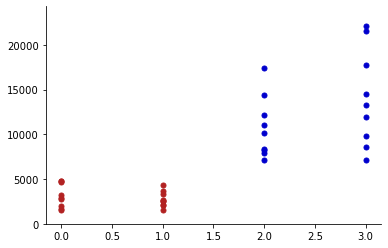

In [197]:
fig, ax = plt.subplots(1,1, figsize)
x_jitter = np.random.uniform(c-0.2, c+0.2, np.size(Lgaze_count,0))
ax.plot(np.ones(np.size(Lgaze_count,0))*0, Lgaze_count, '.', color=colors['gaze'], markersize=12)
ax.plot(np.ones(np.size(Lgaze_count,0))*1, Rgaze_count, '.', color=colors['gaze'], markersize=12)
ax.plot(np.ones(np.size(Lgaze_count,0))*2, Lcomp_count, '.', color=colors['comp'], markersize=12)
ax.plot(np.ones(np.size(Lgaze_count,0))*3, Rcomp_count, '.', color=colors['comp'], markersize=12)
maxval = np.max([Lgaze_count, Rgaze_count, Lcomp_count, Rcomp_count])
ax.set_ylim([0,maxval*1.1])

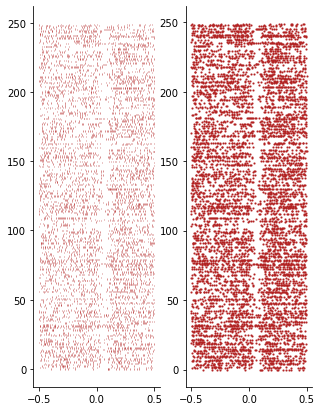

In [30]:
fig = plt.subplots(1,2,figsize=(5,7))
ax0 = plt.subplot(121)
ax1 = plt.subplot(122)
for n, s in enumerate(plot_gs):
    sp = row['FmLt_spikeT']-s
    sp = sp[np.abs(sp)<=0.5]
    ax0.vlines(sp, n-0.5, n+0.5, color=colors['gaze'], linewidth=0.5)
    ax1.plot(sp, np.ones(sp.size)*n, 's', color=colors['gaze'], markersize=1)

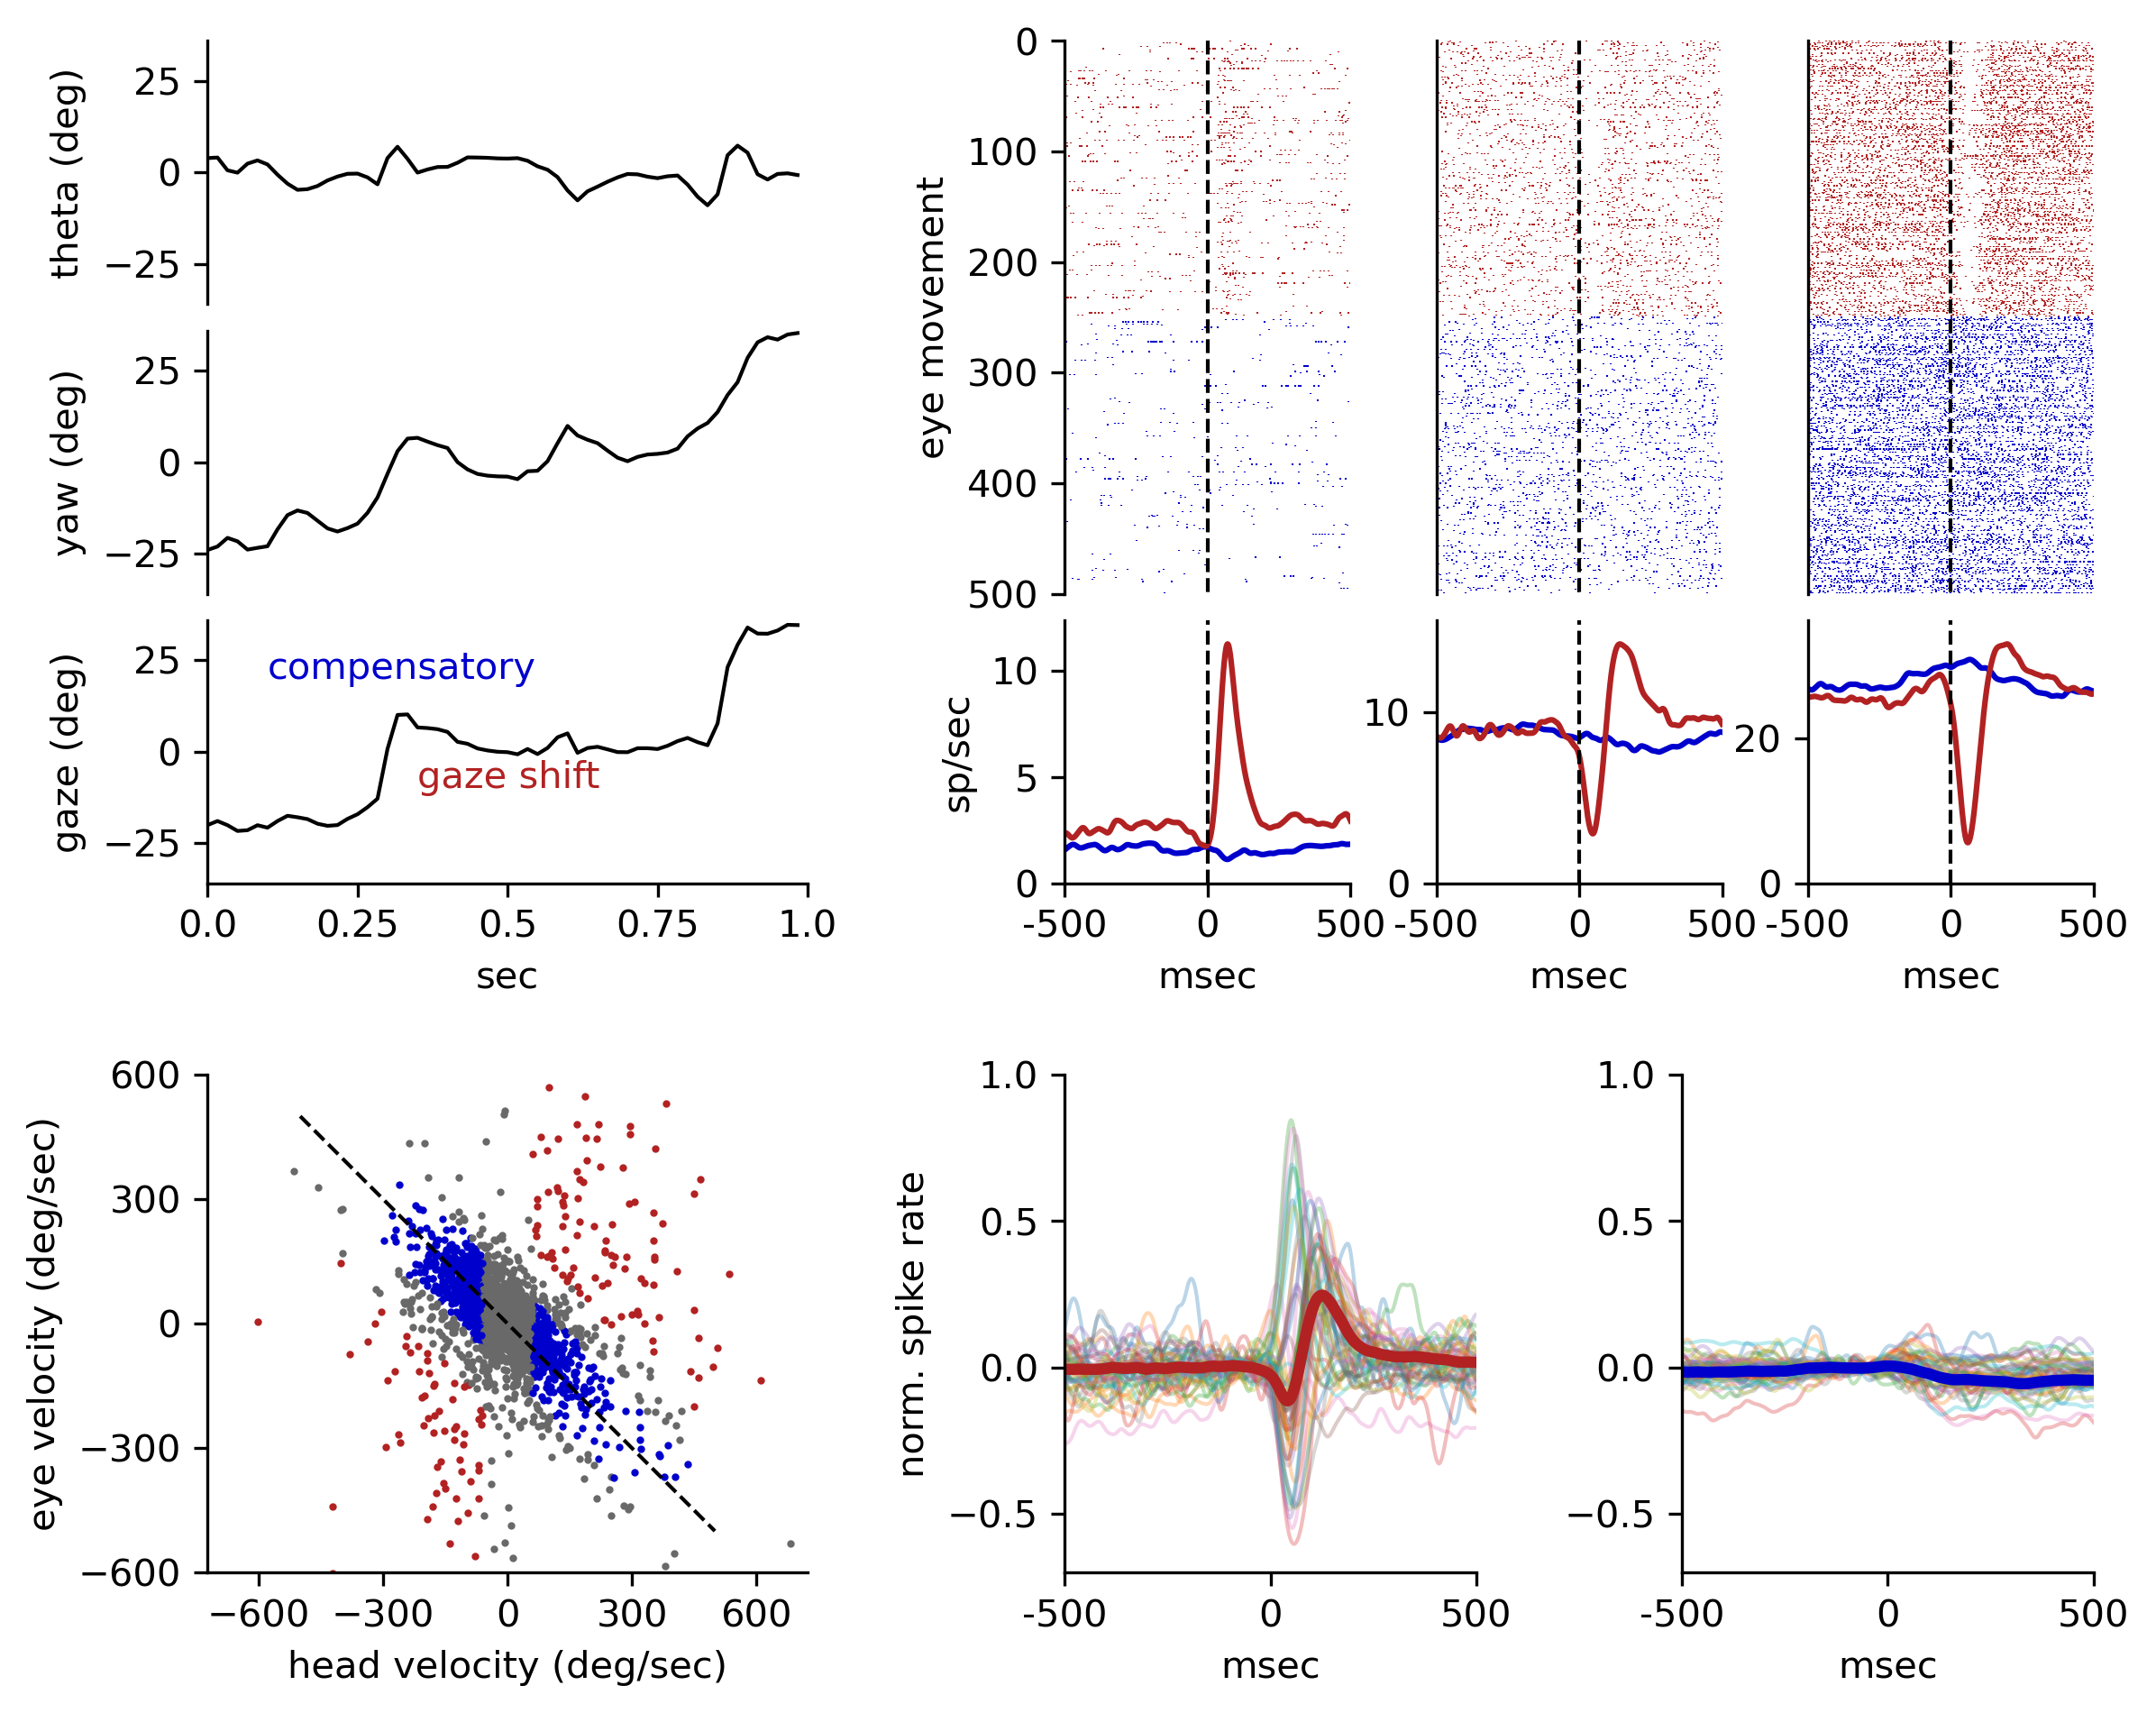

In [31]:
fig1 = plt.figure(constrained_layout=False, figsize=(9,7.5), dpi=300)
fig1spec = gridspec.GridSpec(nrows=5, ncols=5, figure=fig1, wspace=1.5, hspace=1.25)

fig1Cspec = gridspec.GridSpecFromSubplotSpec(3,1,subplot_spec=fig1spec[:3,:2], wspace=0, hspace=0.1)
ax_theta = fig1.add_subplot(fig1Cspec[0,0])
ax_yaw = fig1.add_subplot(fig1Cspec[1,0])
ax_gaze = fig1.add_subplot(fig1Cspec[2,0])

fig1Dspec = gridspec.GridSpecFromSubplotSpec(1,1,subplot_spec=fig1spec[3:5,:2], wspace=0, hspace=0)
ax_dEyeHead = fig1.add_subplot(fig1Dspec[0,0])

fig1E2Fspec = gridspec.GridSpecFromSubplotSpec(3,3,subplot_spec=fig1spec[:3,2:], wspace=0.3, hspace=0.1)
ax_pos_raster = fig1.add_subplot(fig1E2Fspec[0:2,0])
ax_biph_raster = fig1.add_subplot(fig1E2Fspec[0:2,1])
ax_neg_raster = fig1.add_subplot(fig1E2Fspec[0:2,2])
ax_pos_psth = fig1.add_subplot(fig1E2Fspec[2,0])
ax_biph_psth = fig1.add_subplot(fig1E2Fspec[2,1])
ax_neg_psth = fig1.add_subplot(fig1E2Fspec[2,2])

fig1Gspec = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec=fig1spec[3:,2:], wspace=0.5, hspace=0.25)
ax_ex_gaze = fig1.add_subplot(fig1Gspec[0,0])
ax_ex_comp = fig1.add_subplot(fig1Gspec[0,1])
# ax_gaze_vs_comp = fig1.add_subplot(fig1Gspec[:,2])

start = 2090 #2100
win = 60 # frames, not sec
ex_units = [151,82,155]
ex_units_direcprefs = ['left','right','left']

ylim_val = 36
theta_data = demo['FmLt_theta'][start:start+win]
theta_data = theta_data - np.nanmean(theta_data)
ax_theta.plot(theta_data, 'k-', linewidth=1, scaley=10)
ax_theta.set_xlim([0,60]); ax_theta.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax_theta.set_ylabel('theta (deg)')
ax_theta.set_ylim([-ylim_val,ylim_val])
ax_theta.axes.get_xaxis().set_visible(False)
ax_theta.axes.spines.bottom.set_visible(False)

pYaw = np.nancumsum(demo['FmLt_dHead'][start:start+win]*0.016)
pYaw = pYaw - np.nanmean(pYaw)
ax_yaw.plot(pYaw, 'k-', linewidth=1)
ax_yaw.set_xlim([0,60])
ax_yaw.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax_yaw.set_ylabel('yaw (deg)')
ax_yaw.axes.get_xaxis().set_visible(False)
ax_yaw.axes.spines.bottom.set_visible(False)
ax_yaw.set_ylim([-ylim_val,ylim_val])

ax_gaze.plot(pYaw + theta_data, 'k-', linewidth=1)
ax_gaze.set_xlim([0,60])
ax_gaze.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax_gaze.set_ylabel('gaze (deg)')
ax_gaze.set_ylim([-ylim_val,ylim_val])
ax_gaze.set_xlabel('sec')
ax_gaze.annotate('gaze shift', xy=[60*.35,-10], color=colors['gaze'])
ax_gaze.annotate('compensatory', xy=[60*.1,20], color=colors['comp'])
# for i in sacfix_gazeshift:
#     ax_theta.plot([i, i+1], (theta_data)[i:i+2], '-', color=colors['gaze'], linewidth=2)
#     ax_yaw.plot([i, i+1], (pYaw)[i:i+2], '-', color=colors['gaze'], linewidth=2)
#     ax_gaze.plot([i, i+1], (pYaw+theta_data)[i:i+2], '-', color=colors['gaze'], linewidth=2)
# for i in sacfix_comp:
#     ax_theta.plot([i, i+1], (theta_data)[i:i+2], '-', color=colors['comp'], linewidth=2)
#     ax_yaw.plot([i, i+1], (pYaw)[i:i+2], '-', color=colors['comp'], linewidth=2)
#     ax_gaze.plot([i, i+1], (pYaw+theta_data)[i:i+2], '-', color=colors['comp'])

for i in plotinds:
    dGaze_i = np.abs(dHead_data[i]+dEye_data[i])
    if eyeT[i] in gazemovs:
        c = colors['gaze']
    elif eyeT[i] in comp:
        c = colors['comp']
    elif (np.abs(dHead_data[i])<60) or ((dGaze_i<240) and (dGaze_i>120)):
        c = 'dimgray'
    else:
        continue
    ax_dEyeHead.plot(dHead_data[i], dEye_data[i], '.', color=c, markersize=2)

ax_dEyeHead.axis('equal')
ax_dEyeHead.set_xlim([-600,600])
ax_dEyeHead.set_ylim([-600,600])
ax_dEyeHead.set_xlabel('head velocity (deg/sec)')
ax_dEyeHead.set_ylabel('eye velocity (deg/sec)')
ax_dEyeHead.plot([-500,500],[500,-500], linestyle='dashed', color='k', linewidth=1)
# ax_dEyeHead.annotate('left', xy=[350,500], color='k')
# ax_dEyeHead.annotate('right', xy=[-550,-500], color='k')
# ax_dEyeHead.annotate('gaze shift', xy=[-620,470], color=colors['gaze'])
# ax_dEyeHead.annotate('compensated', xy=[-620,550], color=colors['comp'])
ax_dEyeHead.set_xticks(np.linspace(-600,600,5))
ax_dEyeHead.set_yticks(np.linspace(-600,600,5))

num_movements = 250
raster_panels = [ax_pos_raster, ax_biph_raster, ax_neg_raster]
sdf_panels = [ax_pos_psth, ax_biph_psth, ax_neg_psth]
for i, u in enumerate(ex_units):
    row = hffm.data.iloc[u]
    raster_panel = raster_panels[i]
    sdf_panel = sdf_panels[i]
    LR = ex_units_direcprefs[i]

    gazeshifts = row['FmLt_gazeshift_{}_saccTimes_dHead'.format(LR)].copy()
    compmovs = np.hstack([row['FmLt_comp_left_saccTimes_dHead'], row['FmLt_comp_right_saccTimes_dHead']])
    
    plot_gs = np.random.choice(gazeshifts, size=num_movements, replace=False)
    plot_cp = np.random.choice(compmovs, size=num_movements, replace=False)

    for n, s in enumerate(plot_gs):
        sp = row['FmLt_spikeT']-s
        sp = sp[np.abs(sp)<=0.5]
        raster_panel.plot(sp, np.ones(sp.size)*n, 's', color=colors['gaze'], markersize=1)

    for n, s in enumerate(plot_cp):
        sp = row['FmLt_spikeT']-s
        sp = sp[np.abs(sp)<=0.5]
        raster_panel.plot(sp, np.ones(sp.size)*n, 's', color=colors['comp'], markersize=1)
    
    height = num_movements*2
    raster_panel.set_ylim([height, 0])
    raster_panel.vlines(0, 0, height, color='k', linewidth=1, linestyle='dashed')
#     raster_panel.set_xlabel('msec')
    if i == 0:
        raster_panel.set_ylabel('eye movement')
    else:
        raster_panel.set_yticks([])
#     raster_panel.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
    raster_panel.set_xticks([])
#     raster_panel.set_title(['Positive','Biphasic','Negative'][i])
    raster_panel.set_xlim([-.5,.5])
    raster_panel.axes.spines.bottom.set_visible(False)
    
    sdf_panel.plot(psth_bins, row['FmLt_comp_{}_saccPSTH_dHead'.format(LR)], color=colors['comp'])
    sdf_panel.plot(psth_bins, row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(LR)], color=colors['gaze'])
    max_fr = np.nanmax(row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(LR)])*1.1
    sdf_panel.set_ylim([0,max_fr])
    sdf_panel.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
    sdf_panel.set_xlim([-.5,.5])
    if i == 0:
        sdf_panel.set_ylabel('sp/sec')
#         sdf_panel.annotate('gaze shift', xy=[-.5,14], color=colors['gaze'])
#         sdf_panel.annotate('compensatory', xy=[-.5,17], color=colors['comp'])
    sdf_panel.set_xlabel('msec')
    sdf_panel.vlines(0, 0, max_fr, color='k', linewidth=1, linestyle='dashed')

possible_inds = hffm.data['pref_comp_psth1'][np.std(flatten_series(hffm.data['pref_comp_psth1'])[:,850:1000], axis=1)<0.03].index.values
np.random.seed(3)
example_inds = np.sort(np.random.choice(possible_inds, size=50, replace=False))

for ind in example_inds:
    ax_ex_gaze.plot(psth_bins, hffm.data.loc[ind,'pref_gazeshift_psth1'].astype(float), linewidth=1, alpha=0.3)
    ax_ex_comp.plot(psth_bins, hffm.data.loc[ind,'pref_comp_psth1'].astype(float), linewidth=1, alpha=0.3)
ax_ex_gaze.set_xlim([-.5,.5])#; ax_ex_gaze.set_title('Gaze-shifting')
ax_ex_gaze.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
ax_ex_comp.set_xlim([-.5,.5])#; ax_ex_comp.set_title('Compensatory')
ax_ex_comp.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
ax_ex_gaze.set_ylim([-.7,1])
ax_ex_comp.set_ylim([-.7,1])
ax_ex_gaze.set_ylabel('norm. spike rate')
ax_ex_comp.set_xlabel('msec')
ax_ex_gaze.set_xlabel('msec')

all_comp = flatten_series(hffm.data['pref_comp_psth1'][hffm.data['movcluster']!='unresponsive'])
all_gaze = flatten_series(hffm.data['pref_gazeshift_psth1'][hffm.data['movcluster']!='unresponsive'])

comp_mean = np.nanmedian(all_comp,0)
comp_std = np.std(all_comp,0) / np.sqrt(np.size(all_comp))

gaze_mean = np.nanmedian(all_gaze,0)
gaze_std = np.std(all_gaze,0) / np.sqrt(np.size(all_gaze))

ax_gaze_vs_comp.plot(psth_bins, comp_mean, color=colors['comp'])
ax_gaze_vs_comp.fill_between(psth_bins, comp_mean-comp_std, comp_mean+comp_std, color=colors['comp'], alpha=0.1)
ax_gaze_vs_comp.set_xlim([-0.5,0.5])
ax_gaze_vs_comp.plot(psth_bins, gaze_mean, color=colors['gaze'])
ax_gaze_vs_comp.fill_between(psth_bins, gaze_mean-gaze_std, gaze_mean+gaze_std, color=colors['gaze'], alpha=0.1)
ax_gaze_vs_comp.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
ax_gaze_vs_comp.set_ylim([-0.3,0.3])
ax_gaze_vs_comp.set_xlabel('msec')

ax_ex_comp.plot(psth_bins, comp_mean, color=colors['comp'], linewidth=3)
ax_ex_gaze.plot(psth_bins, gaze_mean, color=colors['gaze'], linewidth=3)

fig1.savefig('/home/niell_lab/Desktop/fig1_050322.pdf')
# pdf.savefig()

In [33]:
sacfix_comp = []
sacfix_gazeshift = []
for i, frame in enumerate(range(start,start+win)):
    t = eyeT[frame]
    if t in left or t in right:
        sacfix_gazeshift.append(i)
    if t in comp:
        sacfix_comp.append(i)

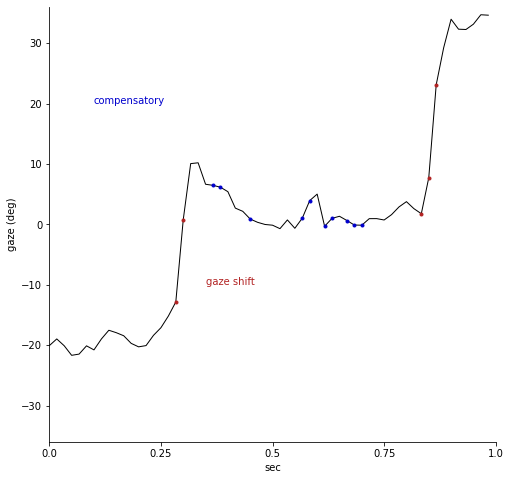

In [34]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(pYaw + theta_data, 'k-', linewidth=1)
ax.set_xlim([0,60])
ax.set_xticks(ticks=np.linspace(0,60,5), labels=np.linspace(0,1,5))
ax.set_ylabel('gaze (deg)')
ax.set_ylim([-ylim_val,ylim_val])
ax.set_xlabel('sec')
ax.annotate('gaze shift', xy=[60*.35,-10], color=colors['gaze'])
ax.annotate('compensatory', xy=[60*.1,20], color=colors['comp'])
for i in sacfix_gazeshift:
    ax.plot(i, (pYaw+theta_data)[i], '.', color=colors['gaze'], linewidth=2)
#     ax.plot([i, i+1], (pYaw+theta_data)[i:i+2], '.', color=colors['gaze'], linewidth=2)
for i in sacfix_comp:
    ax.plot(i, (pYaw+theta_data)[i], '.', color=colors['comp'])
#     ax.plot([i, i+1], (pYaw+theta_data)[i:i+2], '.', color=colors['comp'])

fig.savefig('/home/niell_lab/Desktop/duplicate_saccade_times.pdf')

# Fig 2

In [31]:
def plot_cprop_scatter(panel, prop_name, filter_by=[], row=None, use_median=False, apply_abs=False):
    for c, cluster in enumerate(['early','late','biphasic','negative','unresponsive']):
        if filter_by:
            for filt in filter_by:
                data = hffm.data[hffm.data[filt]==True]
        else:
            data = hffm.data.copy()
        data = data[prop_name][data['movcluster']==cluster]
        if apply_abs is True:
            data = np.abs(data)
        x_jitter = np.random.uniform(c-0.2, c+0.2, np.size(data,0))
        panel.plot(x_jitter, data, '.', color=cat_cmap[cluster], markersize=2)
        if use_median:
            hline = np.median(data)
        elif not use_median:
            hline = np.mean(data)
        panel.hlines(hline, c-0.2, c+0.2, color='k', linewidth=2)
        err = np.std(data) / np.sqrt(np.size(data))
        panel.vlines(c, hline-err, hline+err, color='k', linewidth=2)
        panel.set_xticks(range(5), ['e','l','b','n','u'])
    if row is not None:
        panel.plot(cluster_names.index(row['movcluster']), row[prop_name], '*', color=cat_cmap[cluster_names.index(row['movcluster'])+1], markersize=15, markeredgecolor='k')

In [32]:
for ind, row in hffm.data.iterrows():
    hffm.data.at[ind, 'norm_Sn_psth1'] = normalize_psth(row['Sn_on_background_psth'], baseline_val=row['Sn_on_background_psth'][1000]).astype(object)

In [33]:
for ind, row in hffm.data.iterrows():
    LR = row['pref_gazeshift_direction']
    if LR=='L':
        LR = 'left'
    elif LR=='R':
        LR = 'right'
    psth = row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(LR)].astype(float)
    baseline = np.nanmedian(psth[850:1000])
    hffm.data.at[ind, 'psth_baseline'] = baseline
    hffm.data.at[ind, 'pref_gazeshift_raw_psth1'] = psth.astype(object)
for ind in hffm.data.index.values:
    hffm.data.at[ind, 'psth_peakT'] = psth_bins[np.argmax(hffm.data.loc[ind,'pref_gazeshift_raw_psth1'][1025:1250])+1025]
sorted_df = hffm.data[['psth_peakT','movcluster','pref_gazeshift_psth1','nonpref_gazeshift_psth1','pref_comp_psth1','nonpref_comp_psth1','norm_Rc_psth1','norm_Sn_psth1']].copy()
tseq_unresp = sorted_df.copy()
tseq_unresp = sorted_df[sorted_df['movcluster']=='unresponsive'].sample(frac=1).reset_index(drop=True)
tseq_unresp_pref = flatten_series(tseq_unresp['pref_gazeshift_psth1'])
tseq_unresp_nonpref = flatten_series(tseq_unresp['nonpref_gazeshift_psth1'])
tseq_unresp_comp = flatten_series(tseq_unresp['pref_comp_psth1'])
tseq_unresp_rc = flatten_series(tseq_unresp['norm_Rc_psth1'])
tseq_unresp_sn = flatten_series(tseq_unresp['norm_Sn_psth1'])

sorted_df.sort_values(by='psth_peakT', inplace=True)
sorted_df = sorted_df[sorted_df['movcluster']!='unresponsive'].reset_index()
tseq_pref = flatten_series(sorted_df['pref_gazeshift_psth1'].copy())
tseq_nonpref = flatten_series(sorted_df['nonpref_gazeshift_psth1'].copy())
tseq_comp = flatten_series(sorted_df['pref_comp_psth1'].copy())
tseq_rc = flatten_series(sorted_df['norm_Rc_psth1'].copy())
tseq_sn = flatten_series(sorted_df['norm_Sn_psth1'].copy())

In [34]:
tseq_pref1 = np.vstack([tseq_pref, tseq_unresp_pref])
tseq_nonpref1 = np.vstack([tseq_nonpref, tseq_unresp_nonpref])
tseq_comp1 = np.vstack([tseq_comp, tseq_unresp_comp])
tseq_rc1 = np.vstack([tseq_rc, tseq_unresp_rc])
tseq_sn1 = np.vstack([tseq_sn, tseq_unresp_sn])

In [35]:
tseq_legend_col = sorted_df['movcluster'].copy()
tseq_legend = np.zeros([len(tseq_legend_col.index.values), 1, 4])
for i, n in enumerate(tseq_legend_col):
    tseq_legend[i,:,:] = cat_cmap[n]

In [48]:
import matplotlib as mpl

In [49]:
ucmap = mpl.colors.to_rgba(cat_cmap['unresponsive'])
ucmap

(0.4117647058823529, 0.4117647058823529, 0.4117647058823529, 1.0)

In [50]:
u = np.zeros([np.size(tseq_unresp_pref,0), 1, 4])
for x in range(4):
    u[:,:,x] = ucmap[x]

In [51]:
tseq_legend1 = np.vstack([tseq_legend, u])

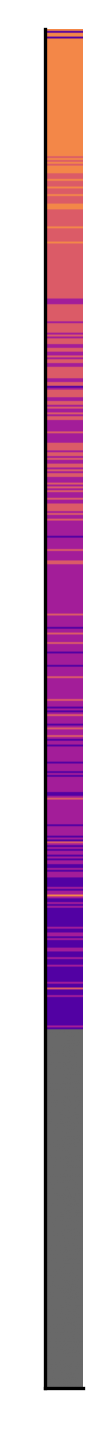

In [52]:
fig, ax = plt.subplots(1,1,figsize=(1,6), dpi=300)
ax.imshow(tseq_legend1, aspect=.05)
ax.set_yticks([]); ax.set_xticks([])
fig.savefig('/home/niell_lab/Desktop/tseq_legend.pdf')

In [36]:
def plot_tempseq(panel, tseq, return_img=False):
    panel.set_xlabel('msec')
    panel.set_ylim([np.size(tseq,0),0])
    img = panel.imshow(tseq, cmap='coolwarm', vmin=-1, vmax=1)
    panel.set_xlim([800,1400])
    panel.set_xticks(np.linspace(800,1400,4), labels=np.linspace(-200,400,4).astype(int))
    panel.vlines(1000, 0, np.size(tseq,0), color='k', linestyle='dashed', linewidth=1)
    if return_img:
        return img

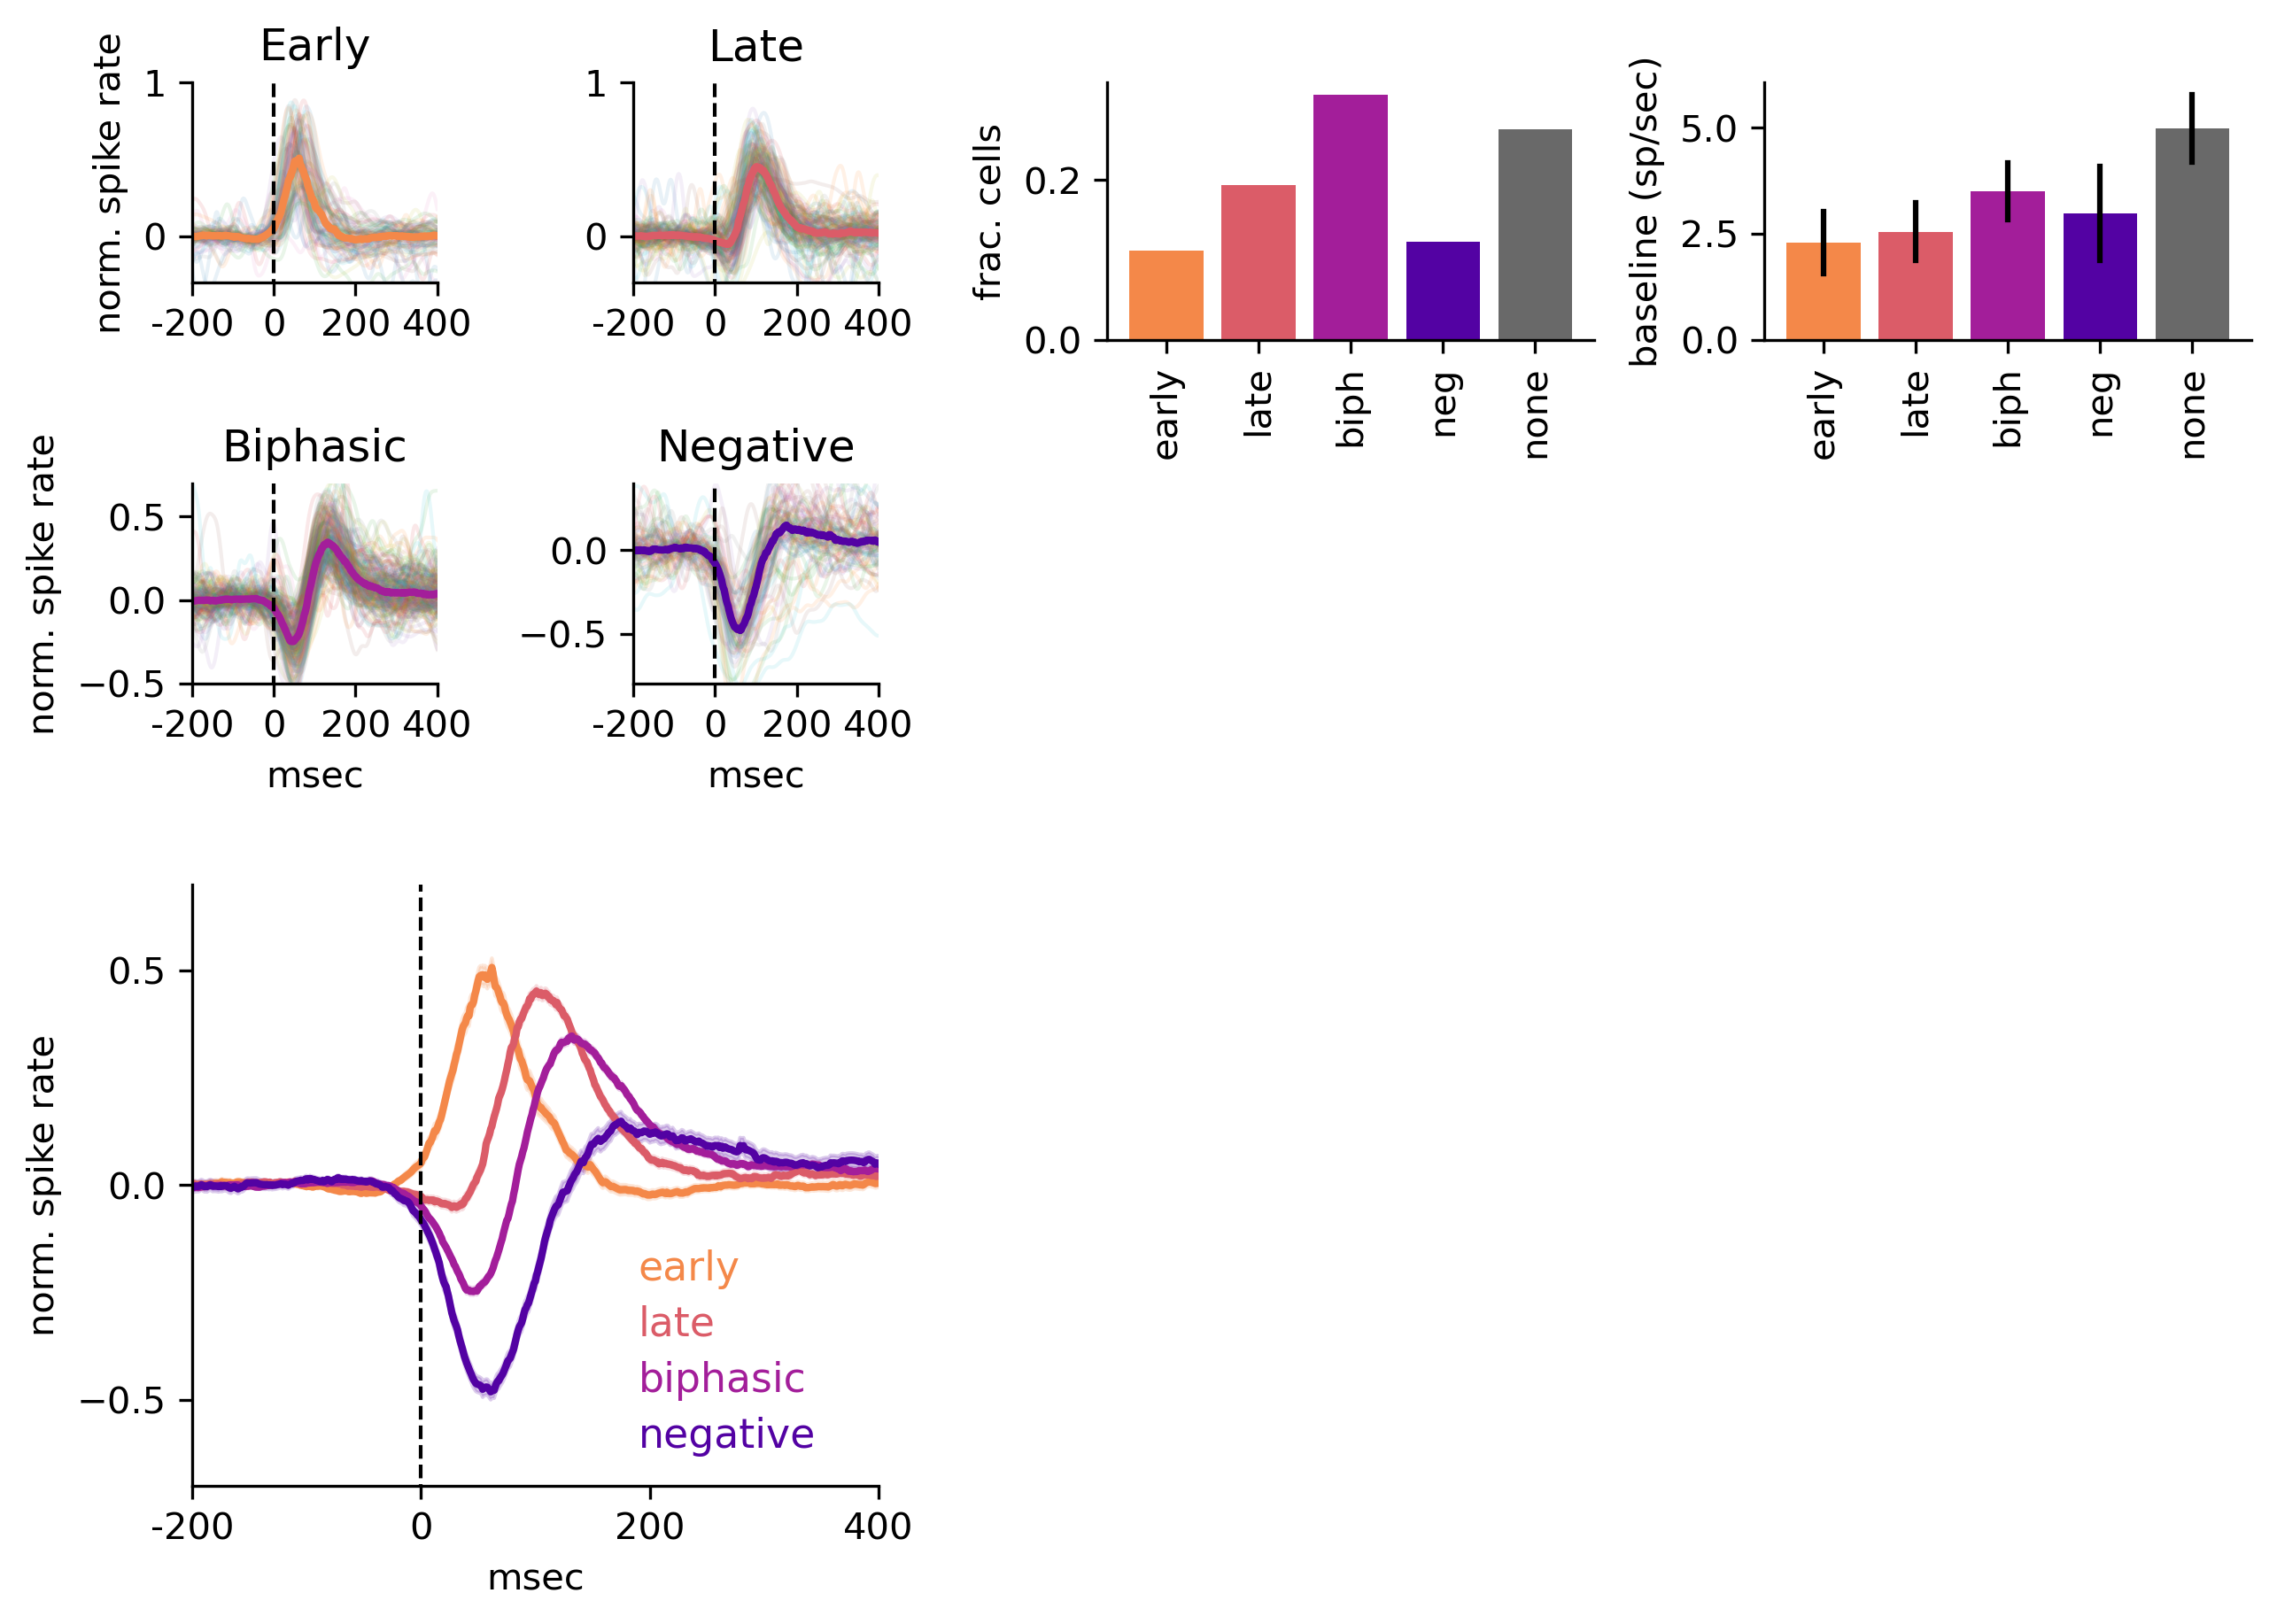

In [56]:
fig2 = plt.figure(constrained_layout=False, figsize=(10,7), dpi=300)
fig2spec = gridspec.GridSpec(nrows=5, ncols=5, figure=fig2, wspace=1, hspace=1.2)

fig2Aspec = gridspec.GridSpecFromSubplotSpec(4,2, subplot_spec=fig2spec[:,0:2], wspace=0.8, hspace=1)
ax_early = fig2.add_subplot(fig2Aspec[0,0])
ax_late = fig2.add_subplot(fig2Aspec[0,1])
ax_biphasic = fig2.add_subplot(fig2Aspec[1,0])
ax_negative = fig2.add_subplot(fig2Aspec[1,1])
ax_clusters = fig2.add_subplot(fig2Aspec[2:,:])

fig2B2Dspec = gridspec.GridSpecFromSubplotSpec(3,2, subplot_spec=fig2spec[0:3,2:], wspace=0.35, hspace=0)
ax_cellcounts = fig2.add_subplot(fig2B2Dspec[0,0])
ax_baseline_fr = fig2.add_subplot(fig2B2Dspec[0,1])

# fig2Espec = gridspec.GridSpecFromSubplotSpec(1,4, subplot_spec=fig2spec[3:5,0], wspace=0.7, hspace=0)
# ax_early_depth = fig2.add_subplot(fig2Espec[0,0])
# ax_late_depth = fig2.add_subplot(fig2Espec[0,1])
# ax_biphasic_depth = fig2.add_subplot(fig2Espec[0,2])
# ax_negative_depth = fig2.add_subplot(fig2Espec[0,3])

panels = [ax_early, ax_late, ax_biphasic, ax_negative]
movtypes = ['early','late','biphasic','negative']
for count, panel in enumerate(panels):
    movtype = movtypes[count]
    thisclust = hffm.data['pref_gazeshift_psth1'][hffm.data['movcluster']==movtype]
    for i, psth in enumerate(thisclust):
        panel.plot(psth_bins, psth, '-', linewidth=1, alpha=0.1)
    clustmean = np.nanmedian(flatten_series(thisclust),0)
    panel.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[movtype])
    panel.set_xlim([-0.2,0.4])
    panel.set_title(movtype.capitalize())
    if count == 0 or count == 2:
        panel.set_ylabel('norm. spike rate')
#     else:
#         panel.set_yticklabels([])
    if count == 3 or count == 2:
        panel.set_xlabel('msec')
    panel.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
#     else:
#         panel.set_xticks([])
    panel.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
ax_early.set_ylim([-0.3,1])
ax_late.set_ylim([-0.3,1])
ax_biphasic.set_ylim([-0.5,0.7])
ax_negative.set_ylim([-0.8,0.4])
    

step = 0.13
names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    cluster_psths = flatten_series(hffm.data['pref_gazeshift_psth1'][hffm.data['movcluster']==name])
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2)
ax_clusters.set_xlim([-0.2,0.4]); ax_clusters.set_ylim([-.7,.7])
ax_clusters.annotate('early', xy=[0.19,-0.22], color=cat_cmap['early'], fontsize=11)
ax_clusters.annotate('late', xy=[0.19,-0.22-(step*1)], color=cat_cmap['late'], fontsize=11)
ax_clusters.annotate('biphasic', xy=[0.19,-0.22-(step*2)], color=cat_cmap['biphasic'], fontsize=11)
ax_clusters.annotate('negative', xy=[0.19,-0.22-(step*3)], color=cat_cmap['negative'], fontsize=11)
ax_clusters.set_ylabel('norm. spike rate'); ax_clusters.set_xlabel('msec')
ax_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
ax_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_clusters.set_yticks(np.linspace(-0.5,0.5,3))

vcounts = hffm.data['movcluster'].value_counts()
names = ['early','late','biphasic','negative','unresponsive']
print_names = ['early','late','biph','neg','none']
for i, name in enumerate(names):
    ax_cellcounts.bar(i, vcounts[name]/np.sum(vcounts), color=cat_cmap[name])
ax_cellcounts.set_xticks(ticks=range(5), labels=print_names, rotation=90)
ax_cellcounts.set_ylabel('frac. cells')

for i, name in enumerate(names):
    baselines = hffm.data['psth_baseline'][hffm.data['movcluster']==name].to_numpy()
    err = np.std(baselines) / np.sqrt(np.size(baselines))
    med = np.median(baselines)
    ax_baseline_fr.bar(i, med, color=cat_cmap[name])
    ax_baseline_fr.plot([i, i], [med-err, med+err], 'k-')
ax_baseline_fr.set_xticks(range(5), print_names, rotation=90)
ax_baseline_fr.set_ylabel('baseline (sp/sec)')

# plot_cprop_scatter(ax_baseline_fr, 'psth_baseline', use_median=True)
# ax_baseline_fr.set_ylabel('baseline (sp/sec)')
# ax_baseline_fr.set_ylim([0,50])

# panels = [ax_early_depth, ax_late_depth, ax_biphasic_depth, ax_negative_depth]
# names = ['early','late','biphasic','negative']
# for i, panel in enumerate(panels):
#     name = names[i]
#     panel.hist(hffm.data['Wn_depth_from_layer5'], color='k', bins=np.linspace(-650,750,8), orientation='horizontal', density=True, histtype='step', linewidth=2)
#     panel.hist(hffm.data['Wn_depth_from_layer5'][hffm.data['movcluster']==name],
#                         color=cat_cmap[name], bins=np.linspace(-650,750,8), orientation='horizontal', density=True, histtype='stepfilled')
#     panel.set_xlabel('frac. cells')
#     if i == 0:
#         panel.set_ylabel('depth (um)')
#     else:
#         panel.set_yticklabels([])
#     panel.invert_yaxis()
#     panel.set_xlim(0,0.003)
#     panel.set_xticks([0,0.003])

# fig2.savefig('/home/niell_lab/Desktop/fig2_050322.pdf')

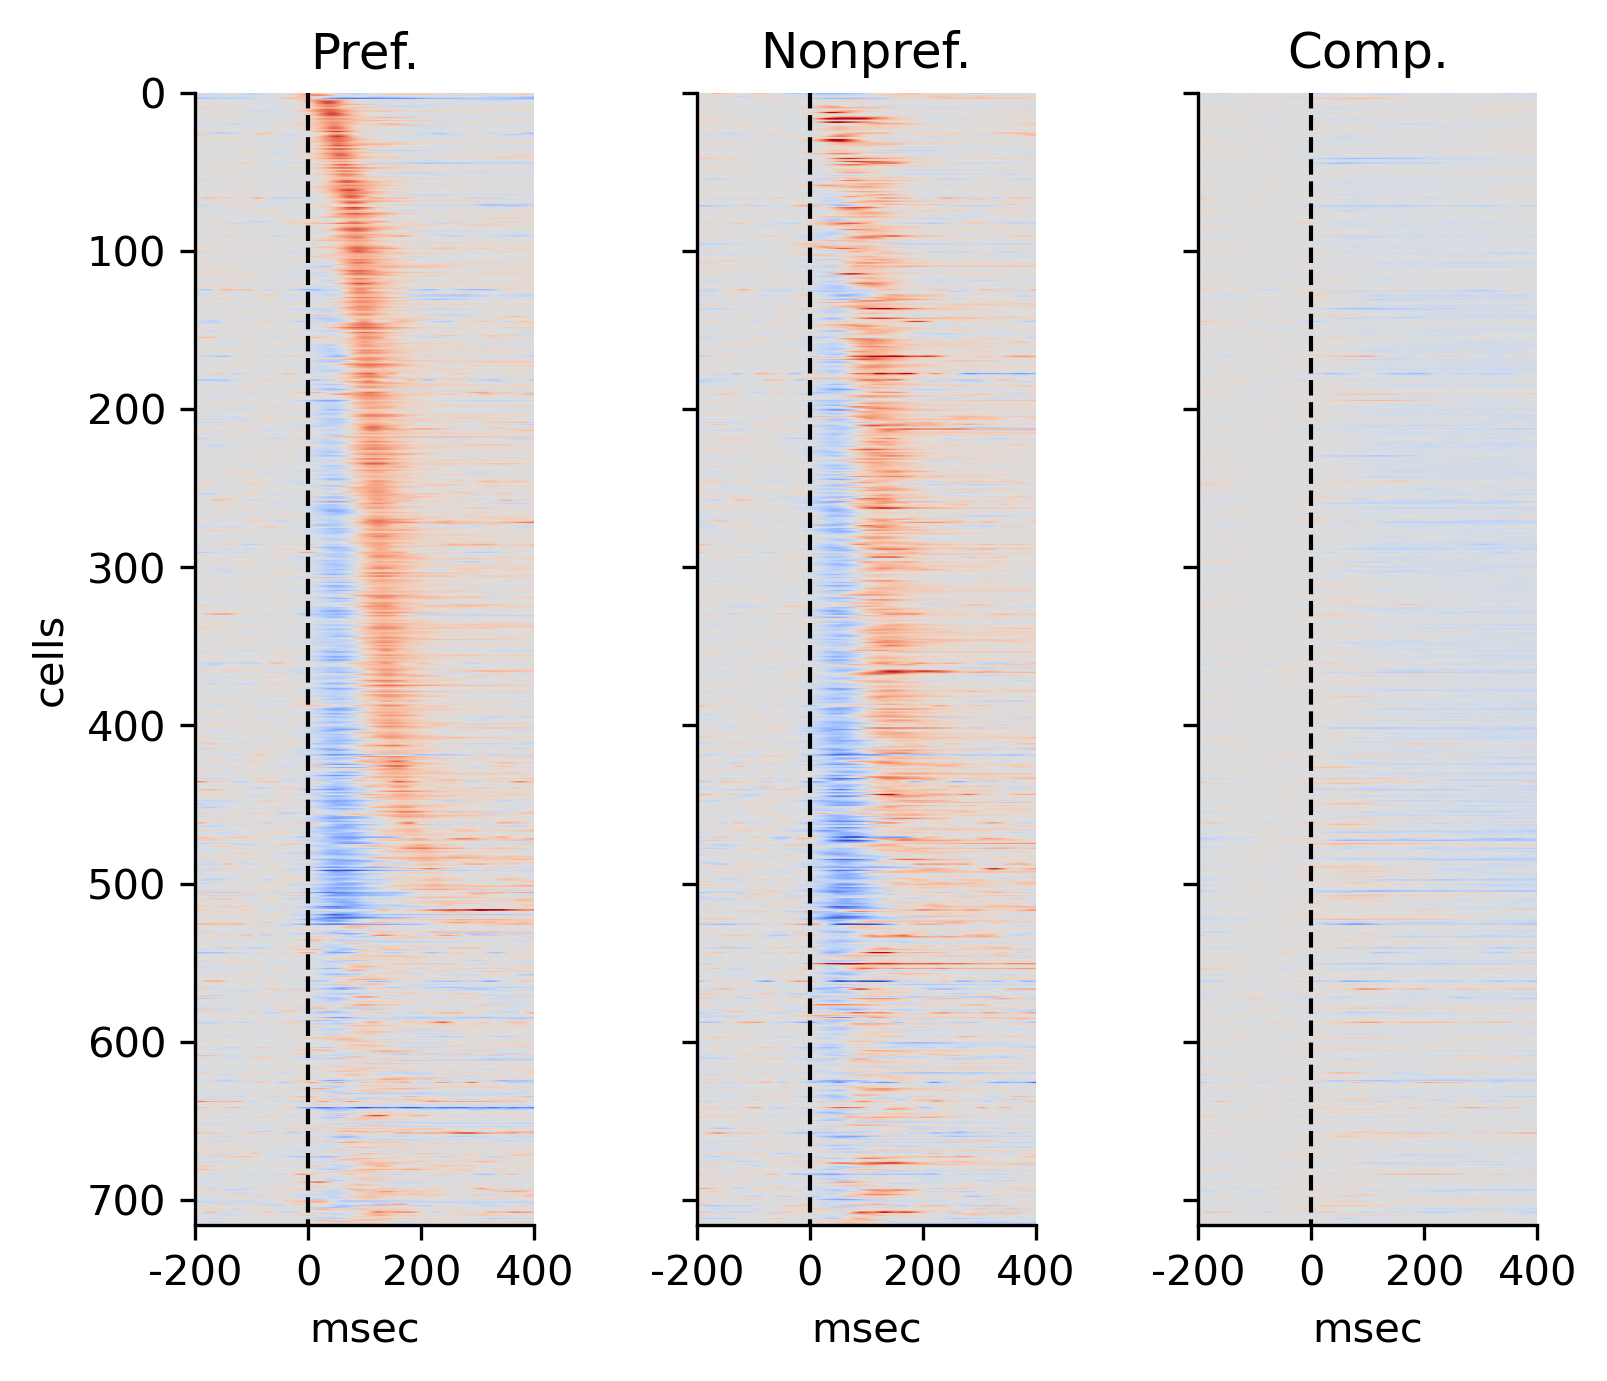

In [58]:
fig2p2 = plt.figure(constrained_layout=False, figsize=(6,5), dpi=300)

fig2p2A = gridspec.GridSpec(1,3, figure=fig2p2, wspace=.28, hspace=.1)
ax_tseq_pref = fig2p2.add_subplot(fig2p2A[:,0])
ax_tseq_nonpref = fig2p2.add_subplot(fig2p2A[:,1])
ax_tseq_comp = fig2p2.add_subplot(fig2p2A[:,2])

tseq_aspect =2.8
img = plot_tempseq(ax_tseq_pref, tseq_pref1, return_img=True)
ax_tseq_pref.set_aspect(tseq_aspect)
ax_tseq_pref.set_title('Pref.')
ax_tseq_pref.set_ylabel('cells')

plot_tempseq(ax_tseq_nonpref, tseq_nonpref1)
ax_tseq_nonpref.set_aspect(tseq_aspect)
ax_tseq_nonpref.set_title('Nonpref.')
ax_tseq_nonpref.set_yticklabels([])

plot_tempseq(ax_tseq_comp, tseq_comp1)
ax_tseq_comp.set_aspect(tseq_aspect)
ax_tseq_comp.set_title('Comp.')
ax_tseq_comp.set_yticklabels([])

fig2p2.savefig('/home/niell_lab/Desktop/fig2p2_050222.pdf')

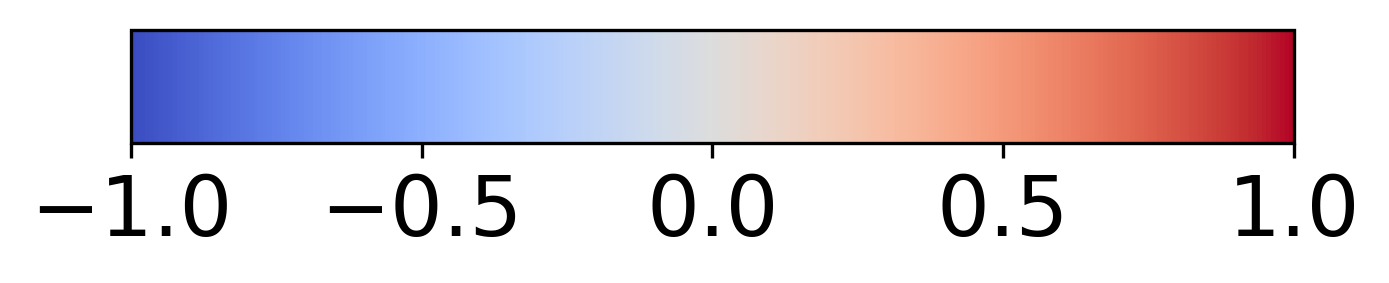

In [59]:
fig, ax = plt.subplots(figsize=(5,.5), dpi=300)
plt.colorbar(img, cax=ax, aspect=10, orientation='horizontal')
plt.xticks(np.linspace(-1,1,5),size=20)
# ax.xaxis.set_tick_params(width=2)
plt.savefig('/home/niell_lab/Desktop/fig2p2_colorbar.pdf', bbox_inches='tight', pad_inches=.5)

(15.0, 0.0)

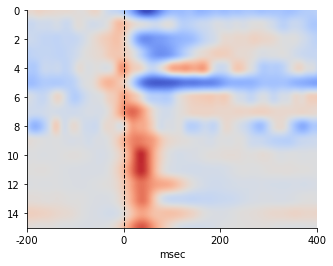

In [116]:
fig, ax = plt.subplots()
plot_tempseq(ax, tseq_pref)
ax.set_aspect(30)
ax.set_ylim(15)
ax.plot()

# Fig 3

In [40]:
for ind, row in ltdk.data.iterrows():
    if row['pref_gazeshift_direction']=='L':
        pref_dir = 'left'
        nonpref_dir = 'right'
    elif row['pref_gazeshift_direction']=='R':
        pref_dir = 'right'
        nonpref_dir = 'left'
    ltdk.data.at[ind, 'pref_gazeshift_raw_psth1'] = row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)].astype(object)
    ltdk.data.at[ind, 'pref_gazeshift_raw_psth1_FmDk'] = row['FmDk_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)].astype(object)
    # light recording
    ltdk.data.at[ind, 'pref_gazeshift_psth1'] = normalize_psth(row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    ltdk.data.at[ind, 'nonpref_gazeshift_psth1'] = normalize_psth(row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(nonpref_dir)], raw_pref=row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    ltdk.data.at[ind, 'pref_comp_psth1'] = normalize_psth(row['FmLt_comp_{}_saccPSTH_dHead'.format(pref_dir)], raw_pref=row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    ltdk.data.at[ind, 'nonpref_comp_psth1'] = normalize_psth(row['FmLt_comp_{}_saccPSTH_dHead'.format(nonpref_dir)], raw_pref=row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    # dark recording
    ltdk.data.at[ind, 'pref_gazeshift_psth1_FmDk'] = normalize_psth(row['FmDk_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    ltdk.data.at[ind, 'nonpref_gazeshift_psth1_FmDk'] = normalize_psth(row['FmDk_gazeshift_{}_saccPSTH_dHead'.format(nonpref_dir)], raw_pref=row['FmDk_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    ltdk.data.at[ind, 'pref_comp_psth1_FmDk'] = normalize_psth(row['FmDk_comp_{}_saccPSTH_dHead'.format(pref_dir)], raw_pref=row['FmDk_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    ltdk.data.at[ind, 'nonpref_comp_psth1_FmDk'] = normalize_psth(row['FmDk_comp_{}_saccPSTH_dHead'.format(nonpref_dir)], raw_pref=row['FmDk_gazeshift_{}_saccPSTH_dHead'.format(pref_dir)]).astype(object)
    

In [41]:
for ind, row in ltdk.data.iterrows():
    psth = row['pref_gazeshift_raw_psth1'].astype(float)
    baseline = np.nanmean(psth[850:1000])
    ltdk.data.at[ind, 'psth_baseline'] = baseline
for ind in ltdk.data.index.values:
    ltdk.data.at[ind, 'psth_peakT'] = psth_bins[np.argmax(ltdk.data.loc[ind,'pref_gazeshift_raw_psth1'][1025:1250])+1025]
    ltdk.data.at[ind, 'dark_peakT'] = psth_bins[np.argmax(ltdk.data.loc[ind,'pref_gazeshift_psth1_FmDk'][1025:1250])+1025]
    
    ltdk.data.at[ind, 'psth_troughT'] = psth_bins[np.argmin(ltdk.data.loc[ind,'pref_gazeshift_psth1_FmDk'][1025:1250])+1025]
    ltdk.data.at[ind, 'dark_troughT'] = psth_bins[np.argmin(ltdk.data.loc[ind,'pref_gazeshift_psth1_FmDk'][1025:1250])+1025]

    sorted_df = ltdk.data[['psth_peakT','dark_peakT','psth_troughT','dark_troughT','movcluster','pref_gazeshift_psth1','pref_gazeshift_psth1_FmDk']].copy()

# shuffle unresponsive cells
tseq_unresp = sorted_df.copy()
tseq_unresp = tseq_unresp[tseq_unresp['movcluster']=='unresponsive'].sample(frac=1).reset_index(drop=True)
tseq_l_unresp = flatten_series(tseq_unresp['pref_gazeshift_psth1'].copy())
tseq_d_unresp = flatten_series(tseq_unresp['pref_gazeshift_psth1'].copy())
    
# sort dark by dark times
tseq_dark_sort = sorted_df.copy()
tseq_dark_sort = tseq_dark_sort.sort_values(by='dark_peakT', inplace=True)
tseq_dark_by_dark = np.vstack([flatten_series(tseq_dark_sort['pref_gazeshift_psth1_FmDk'].copy()), tseq_d_unresp])

# cross validate dark sorting
tseq_dark_validate = tseq_dark_sort.copy()

tseq_dark_validation_sort = tseq_dark_validate.copy().sample(frac=0.5)
tseq_dark_validation_test = tseq_dark_validate.copy().drop(index=tseq_dark_validation_sort.index.values)

sort_values(by='dark_peakT', inplace=True)







# sort light/dark by light times
sort_by_light = sorted_df.copy()

sort_by_light.sort_values(by='psth_peakT', inplace=True)
sort_by_light = sort_by_light[sort_by_light['movcluster']!='unresponsive'].reset_index()

tseq_light_by_light = np.vstack([flatten_series(sort_by_light['pref_gazeshift_psth1'].copy()), tseq_l_unresp])
tseq_dark_by_light = np.vstack([flatten_series(sort_by_light['pref_gazeshift_psth1_FmDk'].copy()), tseq_d_unresp])

# cross validate light sorting

In [42]:
model_dt = 0.025
for ind, row in ltdk.data.iterrows():
    modelT = np.arange(0, np.nanmax(row['FmLt_eyeT']), model_dt)
    
    # timing is off sometimes... using eyeT instead of worldT to get maximum length
    # and they can be different by a few frames
    diff = len(modelT) - len(row['FmLt_rate'])
    if diff>0: # modelT is longer
        modelT = modelT[:-diff]
    elif diff<0: # modelT is shorted
        for i in range(np.abs(diff)):
            modelT = np.append(modelT, modelT[-1]+model_dt)
    model_gz = interp1d(row['FmLt_imuT'], row['FmLt_gyro_z'], bounds_error=False)(modelT)
    model_active = np.convolve(np.abs(model_gz), np.ones(int(1/model_dt)), 'same') / len(np.ones(int(1/model_dt)))
    ltdk.data.at[ind, 'FmLt_model_active'] = model_active.astype(object)
    ltdk.data.at[ind, 'FmLt_modelT'] = modelT.astype(object)
    
    modelT = np.arange(0, np.nanmax(row['FmDk_eyeT']), model_dt)
    diff = len(modelT) - len(row['FmDk_rate'])
    if diff>0: # modelT is longer
        modelT = modelT[:-diff]
    elif diff<0: # modelT is shorted
        for i in range(np.abs(diff)):
            modelT = np.append(modelT, modelT[-1]+model_dt)
    model_gz = interp1d(row['FmDk_imuT'], row['FmDk_gyro_z'], bounds_error=False)(modelT)
    model_active = np.convolve(np.abs(model_gz), np.ones(int(1/model_dt)), 'same') / len(np.ones(int(1/model_dt)))
    ltdk.data.at[ind, 'FmDk_model_active'] = model_active.astype(object)
    ltdk.data.at[ind, 'FmDk_modelT'] = modelT.astype(object)

In [43]:
ltdk.data['FmLt_fr'] = ((ltdk.data['FmLt_rate'].apply(np.sum)*0.025) / ltdk.data['FmLt_eyeT'].apply(np.nanmax)).to_numpy()
ltdk.data['FmDk_fr'] = ((ltdk.data['FmDk_rate'].apply(np.sum)*0.025) / ltdk.data['FmDk_eyeT'].apply(np.nanmax)).to_numpy()

In [44]:
FmLt_fr = np.zeros([len(ltdk.data.index.values)])
FmDk_fr = np.zeros([len(ltdk.data.index.values)])
for ind, row in ltdk.data.iterrows():
    ltdk.data.at[ind,'FmLt_active_fr'] = (np.sum(row['FmLt_rate'][row['FmLt_model_active']>40])) / np.size(row['FmLt_modelT'][row['FmLt_model_active']>40])
    ltdk.data.at[ind,'FmLt_inactive_fr'] = (np.sum(row['FmLt_rate'][row['FmLt_model_active']<40])) / np.size(row['FmLt_modelT'][row['FmLt_model_active']<40])
    ltdk.data.at[ind,'FmDk_active_fr'] = (np.sum(row['FmDk_rate'][row['FmDk_model_active']>40])) / np.size(row['FmDk_modelT'][row['FmDk_model_active']>40])
    ltdk.data.at[ind,'FmDk_inactive_fr'] = (np.sum(row['FmDk_rate'][row['FmDk_model_active']<40])) / np.size(row['FmDk_modelT'][row['FmDk_model_active']<40])

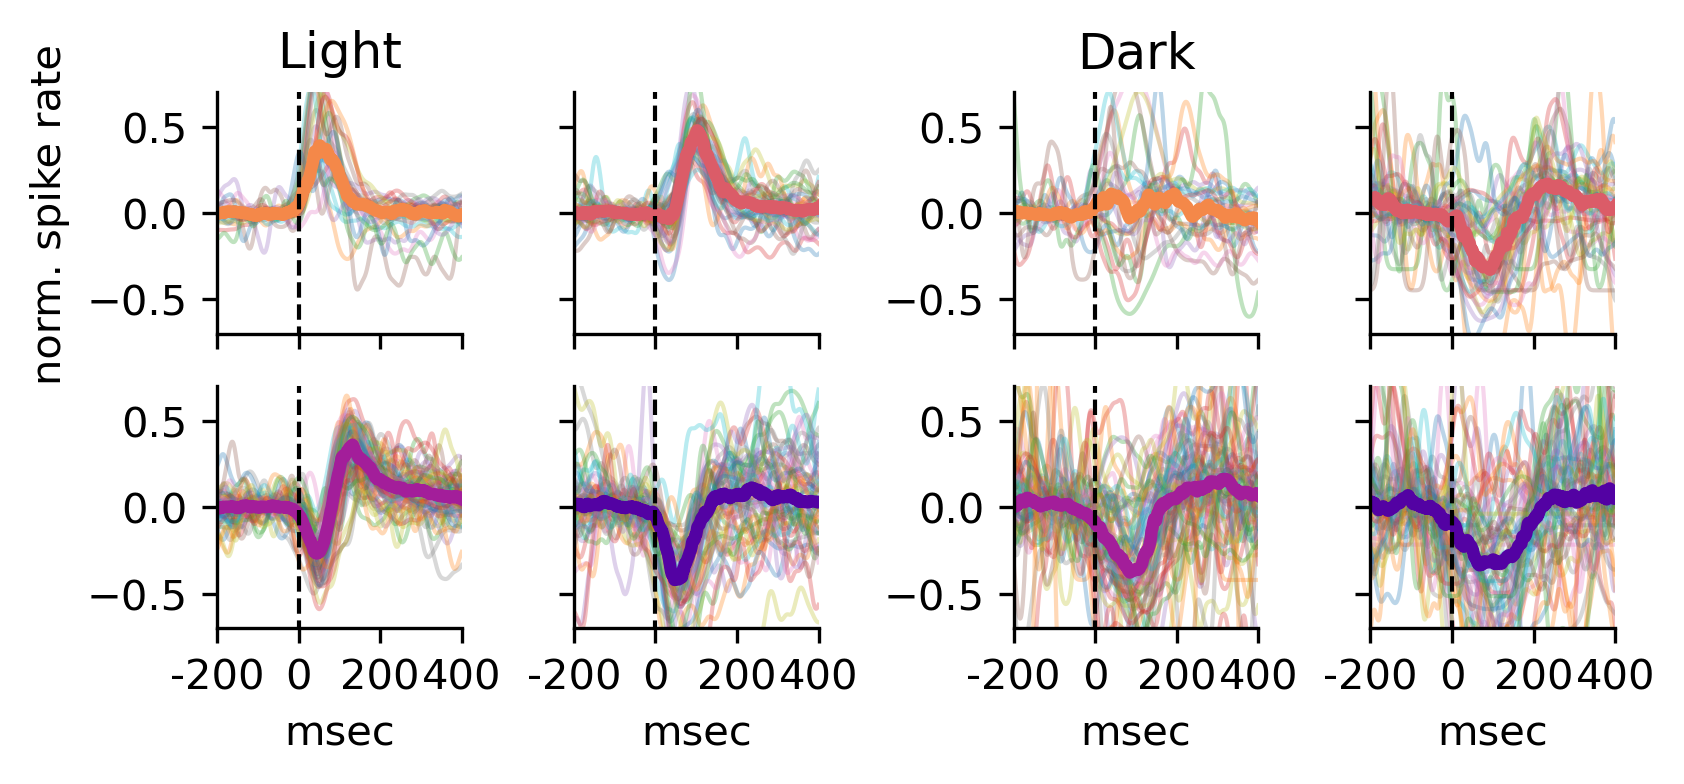

In [65]:
fig3A = plt.figure(constrained_layout=True, figsize=(5.5,2.5), dpi=300)
fig3Aspec = gridspec.GridSpec(nrows=2, ncols=4, figure=fig3A, wspace=0.05, hspace=0.1)

ax_early_l = fig3A.add_subplot(fig3Aspec[0,0])
ax_late_l = fig3A.add_subplot(fig3Aspec[0,1])
ax_biphasic_l = fig3A.add_subplot(fig3Aspec[1,0])
ax_negative_l = fig3A.add_subplot(fig3Aspec[1,1])

ax_early_d = fig3A.add_subplot(fig3Aspec[0,2])
ax_late_d = fig3A.add_subplot(fig3Aspec[0,3])
ax_biphasic_d = fig3A.add_subplot(fig3Aspec[1,2])
ax_negative_d = fig3A.add_subplot(fig3Aspec[1,3])

names = ['early','late','biphasic','negative']
light_panels = [ax_early_l, ax_late_l, ax_biphasic_l, ax_negative_l]
dark_panels = [ax_early_d, ax_late_d, ax_biphasic_d, ax_negative_d]

for count, name in enumerate(names):
    lpanel = light_panels[count]; dpanel = dark_panels[count]
    
    for x in ltdk.data['pref_gazeshift_psth1'][ltdk.data['movcluster']==name]:
        lpanel.plot(psth_bins, x, '-', linewidth=1, alpha=.3)
    lpanel.plot(psth_bins, np.nanmedian(flatten_series(ltdk.data['pref_gazeshift_psth1'][ltdk.data['movcluster']==name]),0), '-', linewidth=3, color=cat_cmap[name])
    lpanel.set_xlim([-0.2,0.4]); lpanel.set_ylim([-.7,.7])
#     lpanel.set_title(name.capitalize())
    lpanel.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
    lpanel.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
    
    for x in ltdk.data['pref_gazeshift_psth1_FmDk'][ltdk.data['movcluster']==name]:
        dpanel.plot(psth_bins, x, '-', linewidth=1, alpha=.3)
    dpanel.plot(psth_bins, np.nanmedian(flatten_series(ltdk.data['pref_gazeshift_psth1_FmDk'][ltdk.data['movcluster']==name]),0), '-', linewidth=3, color=cat_cmap[name])
    dpanel.set_xlim([-0.2,0.4]); dpanel.set_ylim([-.7,.7])
    dpanel.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
    dpanel.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
    
    if name=='early':# or name=='biphasic':
        lpanel.set_ylabel('norm. spike rate')#; dpanel.set_ylabel('norm. spike rate')
    if name=='early' or name=='late':
        lpanel.set_xticklabels([]); dpanel.set_xticklabels([])
    if name=='biphasic' or name=='negative':
        lpanel.set_xlabel('msec'); dpanel.set_xlabel('msec')
    if name=='late' or name=='negative':
        lpanel.set_yticklabels([]); dpanel.set_yticklabels([])
    if name=='early':
        lpanel.set_title('Light'); dpanel.set_title('Dark')
        
fig3A.savefig('/home/niell_lab/Desktop/fig3A.pdf')

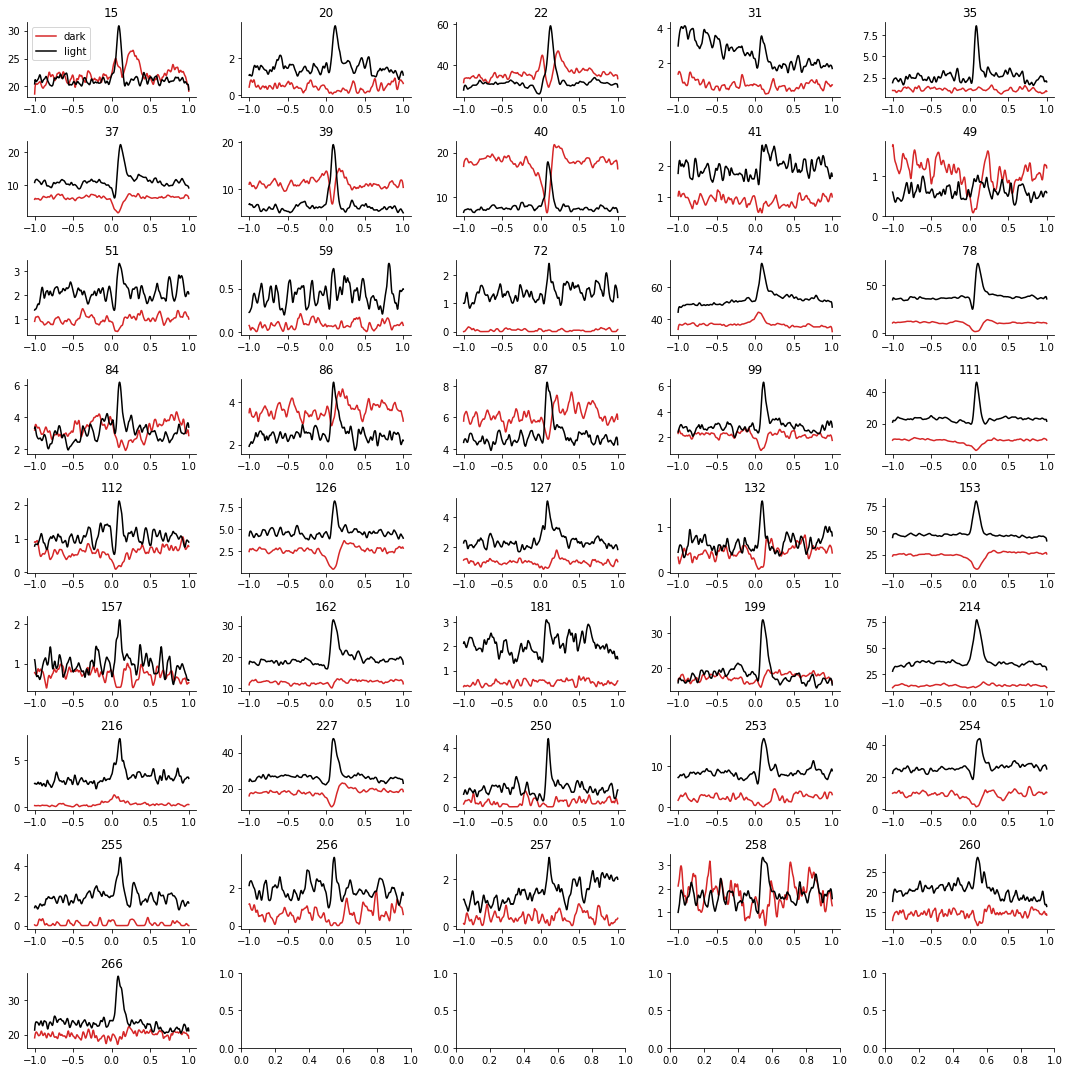

In [82]:
cdata = ltdk.data[ltdk.data['movcluster']=='late'].copy()
num = len(cdata.index.values)
plt.subplots(int(np.ceil(num/5)),5,figsize=(15,15))
for i, ind in enumerate(cdata.index.values):
    plt.subplot(int(np.ceil(num/5)),5,i+1)
    plt.plot(psth_bins, cdata.loc[ind, 'pref_gazeshift_raw_psth1_FmDk'], color='tab:red', label='dark')
    plt.plot(psth_bins, cdata.loc[ind, 'pref_gazeshift_raw_psth1'], color='k', label='light')
    plt.title(ind)
    if i==0:
        plt.legend()
plt.tight_layout()
plt.savefig('/home/niell_lab/Desktop/light_dark_raw.pdf')

In [74]:
[x for x in ltdk.data.columns.values if 'FmDk' in x]

['FmDk_n_spikes',
 'FmDk_spikeT',
 'FmDk_spikeTraw',
 'FmDk_rate',
 'FmDk_contrast_tuning_bins',
 'FmDk_contrast_tuning',
 'FmDk_contrast_tuning_err',
 'FmDk_spike_triggered_average',
 'FmDk_spike_triggered_variance',
 'FmDk_rightsacc_avg',
 'FmDk_leftsacc_avg',
 'FmDk_rightsacc_avg_gaze_shift_dEye',
 'FmDk_leftsacc_avg_gaze_shift_dEye',
 'FmDk_rightsacc_avg_comp_dEye',
 'FmDk_leftsacc_avg_comp_dEye',
 'FmDk_rightsacc_avg_gaze_shift_dHead',
 'FmDk_leftsacc_avg_gaze_shift_dHead',
 'FmDk_rightsacc_avg_comp_dHead',
 'FmDk_leftsacc_avg_comp_dHead',
 'FmDk_pupilradius_tuning_bins',
 'FmDk_pupilradius_tuning',
 'FmDk_pupilradius_tuning_err',
 'FmDk_theta_tuning_bins',
 'FmDk_theta_tuning',
 'FmDk_theta_tuning_err',
 'FmDk_phi_tuning_bins',
 'FmDk_phi_tuning',
 'FmDk_phi_tuning_err',
 'FmDk_gyroz_tuning_bins',
 'FmDk_gyroz_tuning',
 'FmDk_gyroz_tuning_err',
 'FmDk_gyrox_tuning_bins',
 'FmDk_gyrox_tuning',
 'FmDk_gyrox_tuning_err',
 'FmDk_gyroy_tuning_bins',
 'FmDk_gyroy_tuning',
 'FmDk_gyroy_

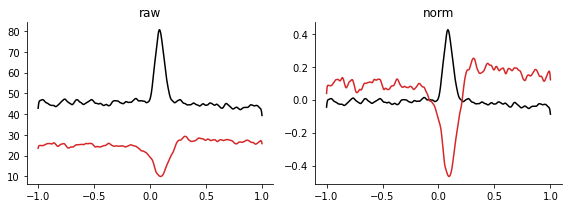

In [81]:
ind = 153

plt.subplots(1,2, figsize=(8,3))

plt.subplot(121)
plt.title('raw')
plt.plot(psth_bins, ltdk.data.loc[ind, 'pref_gazeshift_raw_psth1'], color='k', label='light')
plt.plot(psth_bins, ltdk.data.loc[ind, 'pref_gazeshift_raw_psth1_FmDk'], color='tab:red', label='dark')

plt.subplot(122)
plt.title('norm')
plt.plot(psth_bins, ltdk.data.loc[ind, 'pref_gazeshift_psth1'], color='k')
plt.plot(psth_bins, ltdk.data.loc[ind, 'pref_gazeshift_psth1_FmDk'], color='tab:red')

plt.tight_layout()
plt.savefig('/home/niell_lab/Desktop/light_dark_ind153.pdf')

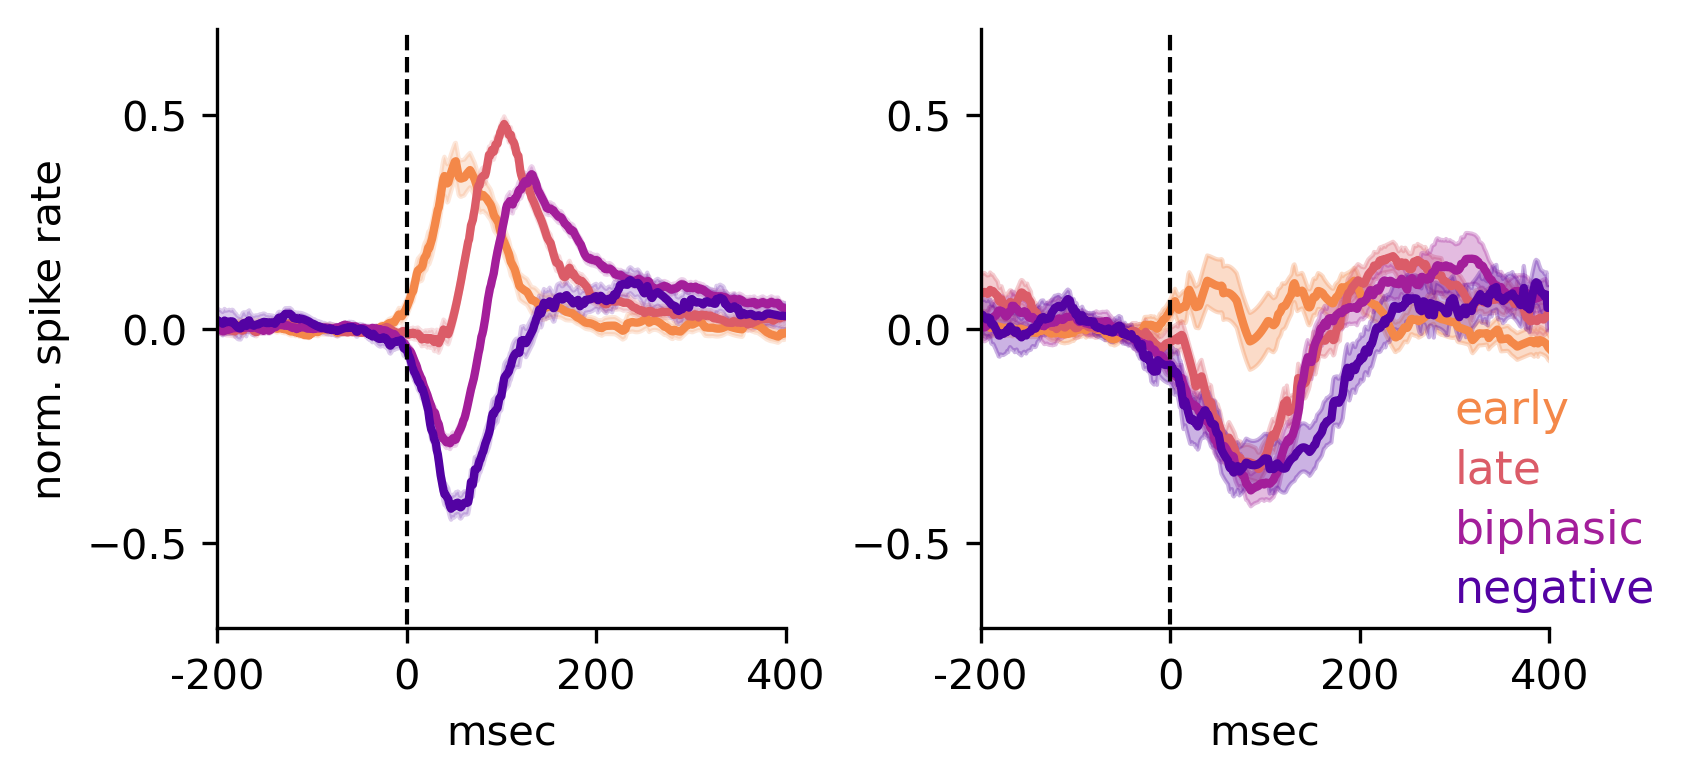

In [83]:
fig3B = plt.figure(constrained_layout=True, figsize=(5.5,2.5), dpi=300)
fig3Bspec = gridspec.GridSpec(nrows=1, ncols=2, figure=fig3B, wspace=0.01, hspace=0)

ax_light_clusters = fig3B.add_subplot(fig3Bspec[:,0])
ax_dark_clusters = fig3B.add_subplot(fig3Bspec[:,1])

step = 0.14
names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    data = ltdk.data[ltdk.data['movcluster']==name]
    cluster_psths = flatten_series(data['pref_gazeshift_psth1'])
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_light_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_light_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2) 
ax_light_clusters.set_xlim([-0.2,0.4]); ax_light_clusters.set_ylim([-.7,.7])
ax_dark_clusters.annotate('early', xy=[0.3,-0.22], color=cat_cmap['early'], fontsize=11)
ax_dark_clusters.annotate('late', xy=[0.3,-0.22-(step*1)], color=cat_cmap['late'], fontsize=11)
ax_dark_clusters.annotate('biphasic', xy=[0.3,-0.22-(step*2)], color=cat_cmap['biphasic'], fontsize=11)
ax_dark_clusters.annotate('negative', xy=[0.3,-0.22-(step*3)], color=cat_cmap['negative'], fontsize=11)
ax_light_clusters.set_ylabel('norm. spike rate'); ax_light_clusters.set_xlabel('msec')
# ax_light_clusters.set_title('Light')
ax_light_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_light_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_light_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

for count, name in enumerate(names):
    data = ltdk.data[ltdk.data['movcluster']==name]
    cluster_psths = flatten_series(data['pref_gazeshift_psth1_FmDk'])
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_dark_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_dark_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.3) 
ax_dark_clusters.set_xlim([-0.2,0.4]); ax_dark_clusters.set_ylim([-.7,.7]); ax_dark_clusters.set_xlabel('msec')
# ax_dark_clusters.set_title('Dark')
ax_dark_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_dark_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_dark_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

fig3B.savefig('/home/niell_lab/Desktop/fig3B.pdf')

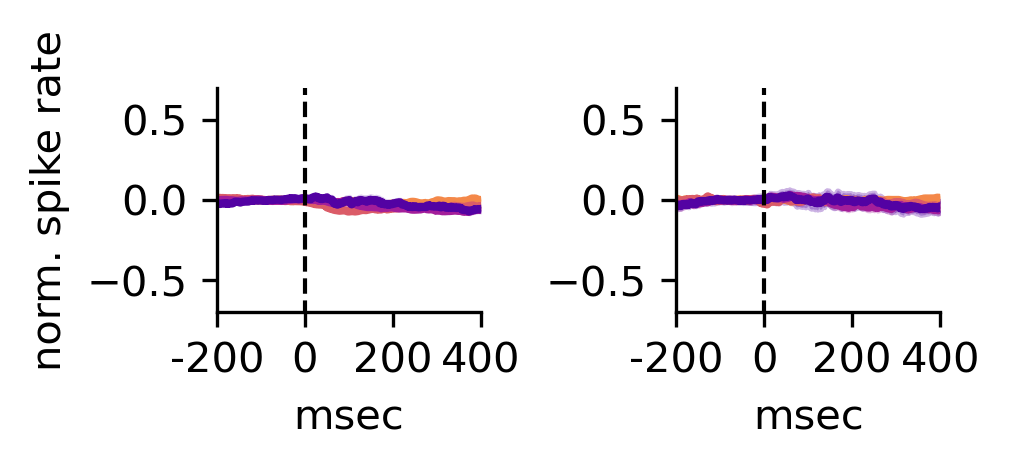

In [48]:
fig3B = plt.figure(constrained_layout=True, figsize=(3.25,1.25), dpi=300)
fig3Bspec = gridspec.GridSpec(nrows=1, ncols=2, figure=fig3B, wspace=0.01, hspace=0)

ax_light_clusters = fig3B.add_subplot(fig3Bspec[:,0])
ax_dark_clusters = fig3B.add_subplot(fig3Bspec[:,1])

step = 0.14
names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    data = ltdk.data[ltdk.data['movcluster']==name]
    cluster_psths = flatten_series(data['pref_comp_psth1'])
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_light_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_light_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2) 
ax_light_clusters.set_xlim([-0.2,0.4]); ax_light_clusters.set_ylim([-.7,.7])
# ax_dark_clusters.annotate('early', xy=[0.3,-0.22], color=cat_cmap['early'], fontsize=11)
# ax_dark_clusters.annotate('late', xy=[0.3,-0.22-(step*1)], color=cat_cmap['late'], fontsize=11)
# ax_dark_clusters.annotate('biphasic', xy=[0.3,-0.22-(step*2)], color=cat_cmap['biphasic'], fontsize=11)
# ax_dark_clusters.annotate('negative', xy=[0.3,-0.22-(step*3)], color=cat_cmap['negative'], fontsize=11)
ax_light_clusters.set_ylabel('norm. spike rate'); ax_light_clusters.set_xlabel('msec')
# ax_light_clusters.set_title('Light')
ax_light_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_light_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_light_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

for count, name in enumerate(names):
    data = ltdk.data[ltdk.data['movcluster']==name]
    cluster_psths = flatten_series(data['pref_comp_psth1_FmDk'])
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_dark_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_dark_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.3) 
ax_dark_clusters.set_xlim([-0.2,0.4]); ax_dark_clusters.set_ylim([-.7,.7]); ax_dark_clusters.set_xlabel('msec')
# ax_dark_clusters.set_title('Dark')
ax_dark_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_dark_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_dark_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

fig3B.savefig('/home/niell_lab/Desktop/comp_ltdk.pdf')

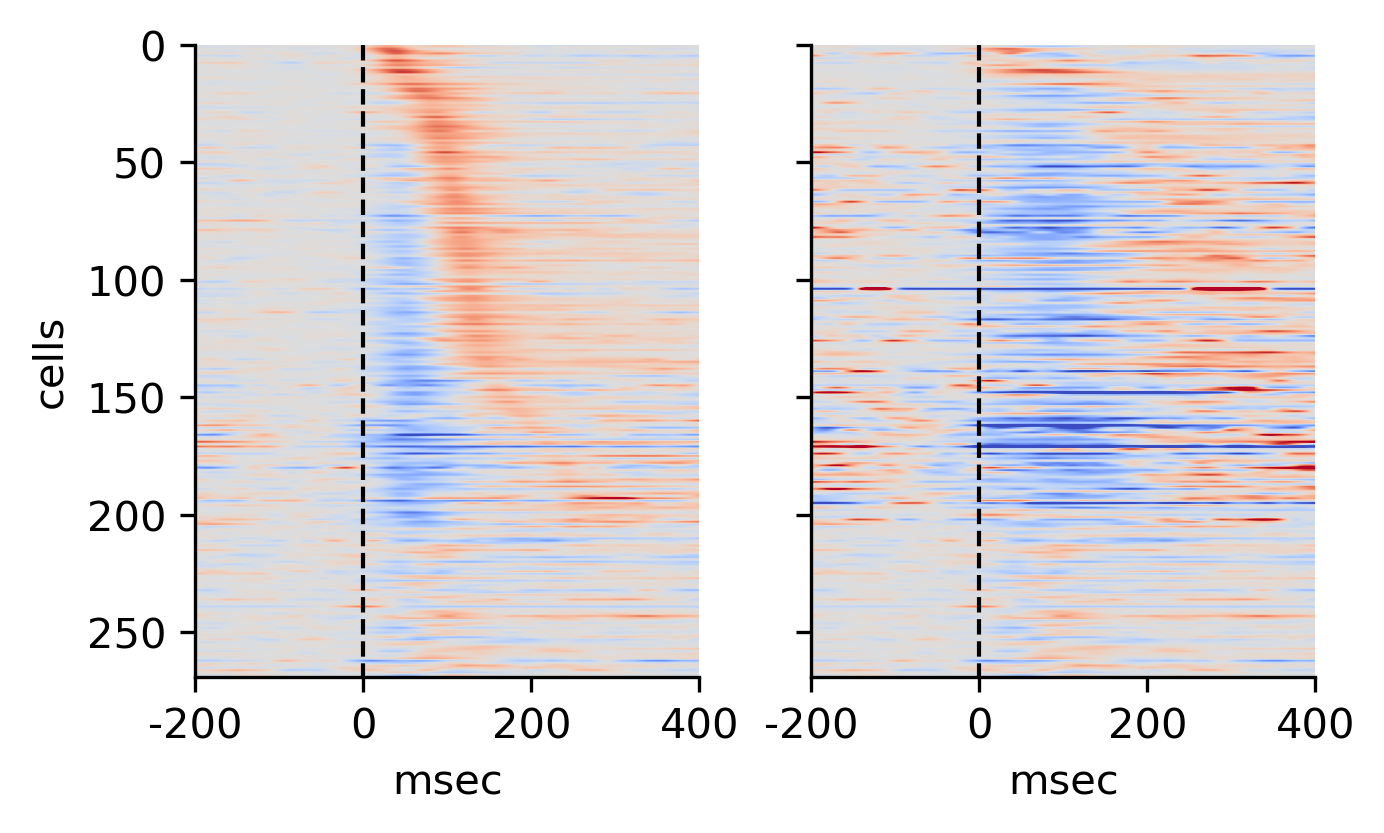

In [91]:
fig3C = plt.figure(constrained_layout=True, figsize=(4.5,6), dpi=300)
fig3Cspec = gridspec.GridSpec(nrows=1, ncols=2, figure=fig3C, wspace=0, hspace=0.5)

ax_tseq_l = fig3C.add_subplot(fig3Cspec[:,0])
ax_tseq_d = fig3C.add_subplot(fig3Cspec[:,1])

tseq_aspect = 2.8
plot_tempseq(ax_tseq_l, tseq_l1)
ax_tseq_l.set_aspect(tseq_aspect)
# ax_tseq_l.set_title('Light')
ax_tseq_l.set_ylabel('cells')

plot_tempseq(ax_tseq_d, tseq_d1)
ax_tseq_d.set_aspect(tseq_aspect)
# ax_tseq_d.set_title('Dark')
ax_tseq_d.set_yticklabels([])

fig3C.savefig('/home/niell_lab/Desktop/fig3C.pdf')

In [92]:
tseq_legend_col = sorted_df['movcluster'].copy()
tseq_legend = np.zeros([len(tseq_legend_col.index.values), 1, 4])
for i, n in enumerate(tseq_legend_col):
    tseq_legend[i,:,:] = cat_cmap[n]

In [93]:
tseq_legend.shape

(204, 1, 4)

In [94]:
ucmap = mpl.colors.to_rgba(cat_cmap['unresponsive'])
ucmap

(0.4117647058823529, 0.4117647058823529, 0.4117647058823529, 1.0)

In [96]:
u = np.zeros([np.size(tseq_l_unresp,0), 1, 4])
for x in range(4):
    u[:,:,x] = ucmap[x]

In [97]:
tseq_legend1 = np.vstack([tseq_legend, u])

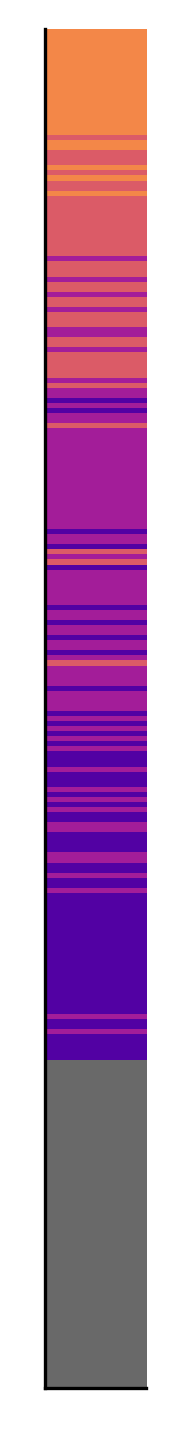

In [98]:
fig, ax = plt.subplots(1,1,figsize=(1,6), dpi=300)
ax.imshow(tseq_legend1, aspect=.05)
ax.set_yticks([]); ax.set_xticks([])
fig.savefig('/home/niell_lab/Desktop/tseq_legend_ltdk.pdf')

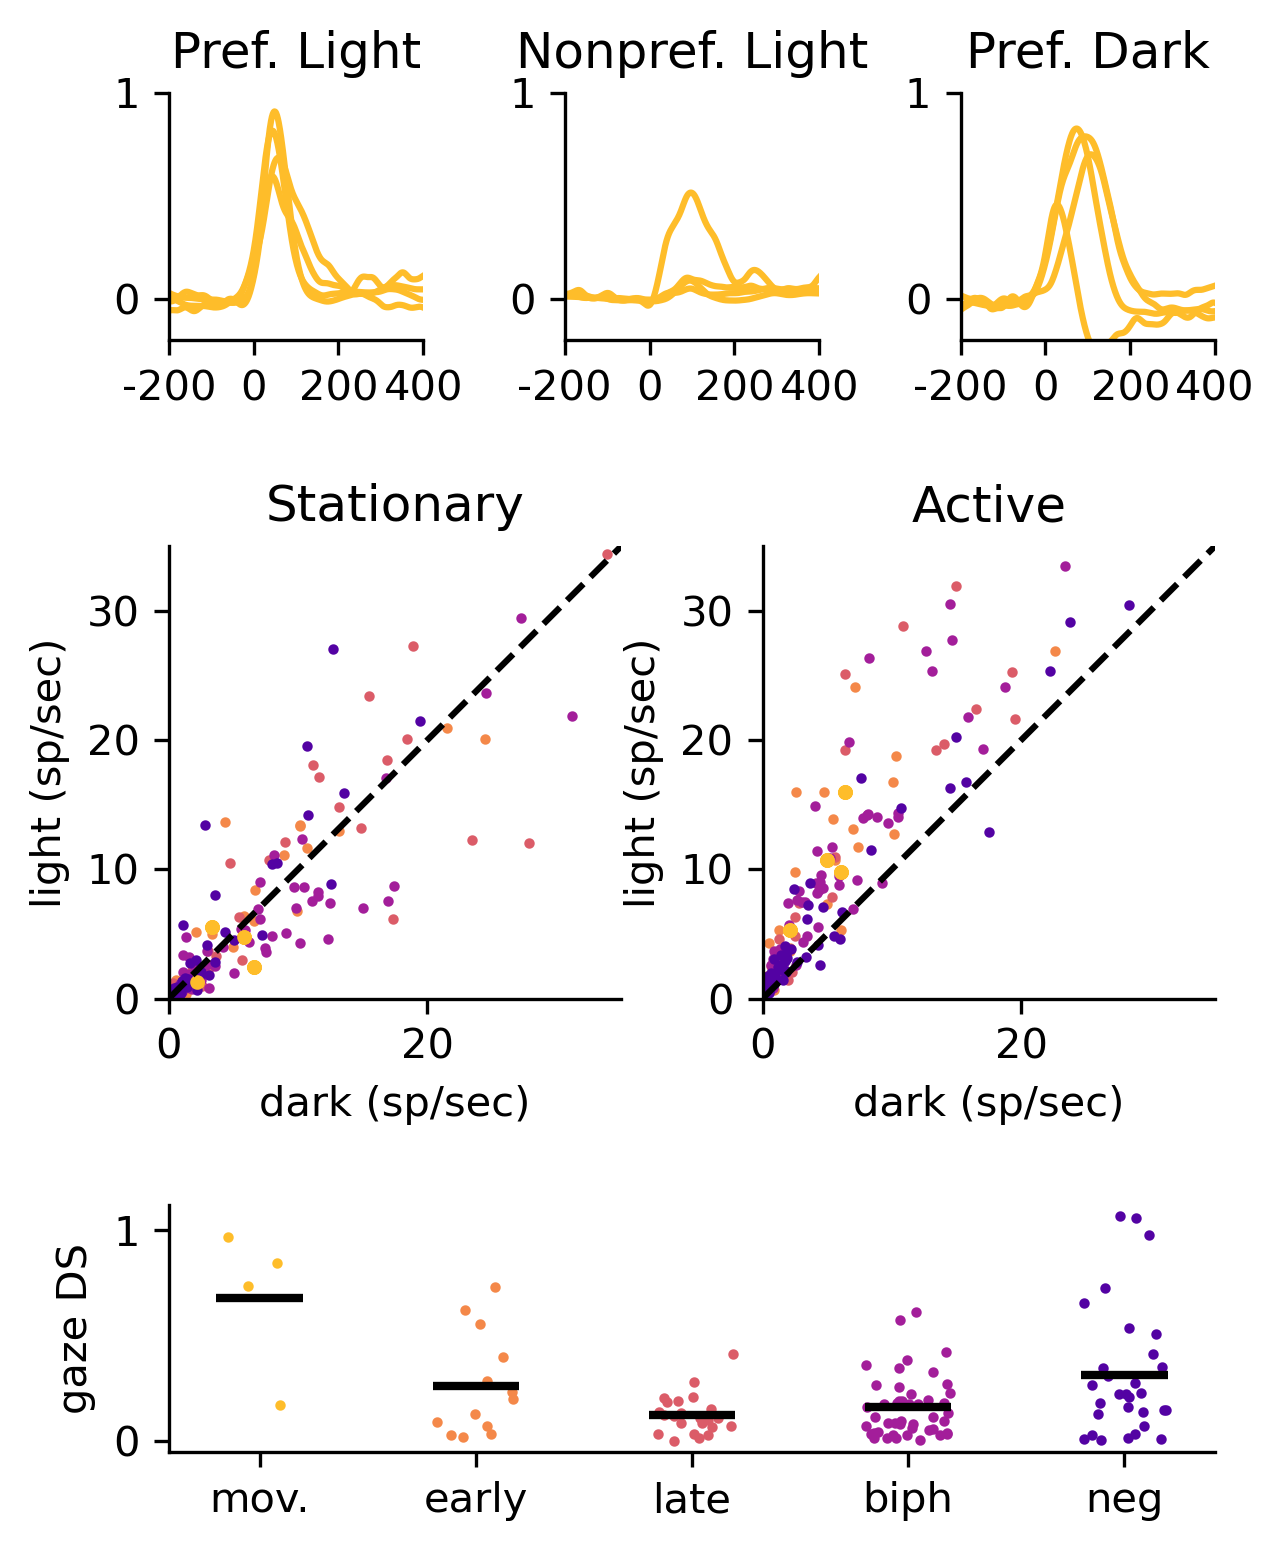

In [101]:
fig3E = plt.figure(constrained_layout=True, figsize=(4.5,6), dpi=300)
fig3Espec = gridspec.GridSpec(nrows=4, ncols=6, figure=fig3E, wspace=2.5, hspace=0.5)

ax_active_light_pref = fig3E.add_subplot(fig3Espec[0,0:2])
ax_active_light_nonpref = fig3E.add_subplot(fig3Espec[0,2:4])
ax_active_dark_pref = fig3E.add_subplot(fig3Espec[0,4:6])

ax_stationary_fr = fig3E.add_subplot(fig3Espec[1:3,0:3])
ax_active_fr = fig3E.add_subplot(fig3Espec[1:3,3:6])

ax_gaze_ds = fig3E.add_subplot(fig3Espec[3,:])

dark_responding = [61,73,183,186]
for ind in dark_responding:
    ax_active_light_pref.plot(psth_bins, ltdk.data.loc[ind,'pref_gazeshift_psth1'], color=cat_cmap['movement'])
    ax_active_light_nonpref.plot(psth_bins, ltdk.data.loc[ind,'nonpref_gazeshift_psth1'], color=cat_cmap['movement'])
    ax_active_dark_pref.plot(psth_bins, ltdk.data.loc[ind,'pref_gazeshift_psth1_FmDk'], color=cat_cmap['movement'])
#     ax_active_dark_nonpref.plot(psth_bins, ltdk.data.loc[ind,'nonpref_gazeshift_psth1_FmDk'], color=cat_cmap['movement'])
ax_active_light_pref.set_xlim([-.15,0.25]); ax_active_light_pref.set_ylim([-.2,1])
ax_active_light_pref.set_title('Pref. Light')
ax_active_dark_pref.set_xlim([-.15,0.25]); ax_active_dark_pref.set_ylim([-.2,1])
ax_active_dark_pref.set_title('Pref. Dark')
ax_active_light_nonpref.set_xlim([-.15,0.25]); ax_active_light_nonpref.set_ylim([-.2,1])
ax_active_light_nonpref.set_title('Nonpref. Light')
# ax_active_dark_nonpref.set_xlim([-.15,0.25]); ax_active_dark_nonpref.set_ylim([-.2,.9])
# ax_active_dark_nonpref.set_title('Nonpref. Dark')
ax_active_light_pref.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_active_light_nonpref.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_active_dark_pref.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
for name in names:
    light_iafr = ltdk.data['FmLt_inactive_fr'][ltdk.data['movcluster']==name].to_numpy()
    dark_iafr = ltdk.data['FmDk_inactive_fr'][ltdk.data['movcluster']==name].to_numpy()
    
    light_afr = ltdk.data['FmLt_active_fr'][ltdk.data['movcluster']==name].to_numpy()
    dark_afr = ltdk.data['FmDk_active_fr'][ltdk.data['movcluster']==name].to_numpy()
    
    for i in range(np.size(light_iafr,0)):
        ax_active_fr.plot(light_iafr[i], light_afr[i], '.', color=cat_cmap[name], markersize=3)
        ax_stationary_fr.plot(dark_iafr[i], dark_afr[i], '.', color=cat_cmap[name], markersize=3)
        
    for ind in dark_responding:
        ax_stationary_fr.plot(ltdk.data.loc[ind,'FmDk_inactive_fr'], ltdk.data.loc[ind,'FmLt_inactive_fr'], '.', color=cat_cmap['movement'], markersize=5)
        ax_active_fr.plot(ltdk.data.loc[ind,'FmDk_active_fr'], ltdk.data.loc[ind,'FmLt_active_fr'], '.', color=cat_cmap['movement'], markersize=5)
        
fr_axis_max = 35
ax_active_fr.axis('square')
ax_stationary_fr.axis('square')
ax_stationary_fr.set_ylim([0,fr_axis_max]); ax_active_fr.set_ylim([0,fr_axis_max])
ax_stationary_fr.set_xlim([0,fr_axis_max]); ax_active_fr.set_xlim([0,fr_axis_max])
ax_stationary_fr.plot([0,35], [0,35], color='k',linestyle='dashed')
ax_active_fr.plot([0,35], [0,35], color='k',linestyle='dashed')
ax_stationary_fr.set_xlabel('dark (sp/sec)'); ax_stationary_fr.set_ylabel('light (sp/sec)')
ax_active_fr.set_title('Active')
ax_active_fr.set_xlabel('dark (sp/sec)'); ax_active_fr.set_ylabel('light (sp/sec)')
ax_stationary_fr.set_title('Stationary')



for c, cluster in enumerate(['movement','early','late','biphasic','negative']):
    if cluster != 'movement':
        data = ltdk.data['gaze_sacc_rlMI'][ltdk.data['movcluster']==cluster].copy()
        if cluster=='early':
            data = data.drop(index=dark_responding).to_numpy()
    elif cluster == 'movement':
        data = ltdk.data.loc[dark_responding, 'gaze_sacc_rlMI'].copy().to_numpy()
    x_jitter = np.random.uniform(c-0.2, c+0.2, np.size(data,0))
    data = np.abs(data)
    ax_gaze_ds.plot(x_jitter, data, '.', color=cat_cmap[cluster], markersize=3)
    ax_gaze_ds.hlines(np.nanmean(data), c-0.2, c+0.2, color='k', linewidth=2)
    ax_gaze_ds.set_xticks(range(5), ['mov.','early','late','biph','neg'])
ax_gaze_ds.set_ylabel('gaze DS')

fig3E.savefig('/home/niell_lab/Desktop/fig3D.pdf')

# Fig 4

In [146]:
ex_units = [151,118,155]
ex_units_direcprefs = ['left','right','left']

In [144]:
for ind in ex_units:
    print(hffm.data['session'].iloc[ind])

070921_J553RT_control_Rig2
070921_J553RT_control_Rig2
070921_J553RT_control_Rig2


In [104]:
path = hffm.data['original_session_path'].iloc[185]

In [105]:
worldpath = find('*revchecker*world.nc', path)[0]

In [106]:
ephyspath = find('*revchecker*ephys_props.h5', path)[0]
ephyspath

'/home/niell_lab/Mounts/Goeppert/nlab-nas/Dylan/freely_moving_ephys/ephys_recordings/070921/J553RT/hf4_revchecker/070921_J553RT_control_Rig2_hf4_revchecker_ephys_props.h5'

In [107]:
origephys = pd.read_hdf(ephyspath)

In [126]:
ephysT0 = origephys['t0'].iloc[0]

In [109]:
import xarray as xr

In [110]:
worldxr = xr.open_dataset(worldpath)
vid = worldxr.WORLD_video.values.astype(np.uint8)
worldT = worldxr.timestamps.values

In [111]:
ind = 185
eyeT = hffm.data['Rc_eyeT'].iloc[ind].copy()
# ephysT0 = hffm.data['Rc_spikeT'].iloc[ind][0]

In [114]:
import cv2

In [115]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
num_frames = np.size(vid, 0); vid_width = np.size(vid, 1); vid_height = np.size(vid, 2)
kmeans_input = vid.reshape(num_frames, vid_width*vid_height)
_, labels, _ = cv2.kmeans(kmeans_input.astype(np.float32), 2, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
label_diff = np.diff(np.ndarray.flatten(labels))

In [127]:
stim_state = interp1d(worldT[:-1]-ephysT0, label_diff, bounds_error=False)(eyeT)
eventT = eyeT[np.where((stim_state<-0.1)+(stim_state>0.1))]

In [ ]:
# Rc_psth = np.zeros([len(self.Rc_ephys.index.values), 2001]) # shape = [unit#, time]
# for i, ind in tqdm(enumerate(self.Rc_ephys.index.values)):
#     unit_spikeT = self.Rc_ephys.loc[ind, 'spikeT']
#     if len(unit_spikeT)<5: # if a unit never fired during revchecker
#         continue
#     Rc_psth[i,:] = calc_kde_sdf(unit_spikeT, eventT)[1]

In [191]:
hffm.data['session'].unique()

array(['062921_G6HCK1ALTRN_control_Rig2', '070921_J553RT_control_Rig2',
       '101521_J559NC_control_Rig2', '102621_J558NC_control_Rig2',
       '110321_J558LT_control_Rig2', '110421_J569LT_control_Rig2',
       '122021_J581RT_control_Rig2', '020222_J577TT_control_Rig2',
       '020422_J577RT_control_Rig2'], dtype=object)

In [135]:
[x for x in hffm.data.columns.values if 'pref' in x]

['sf_pref',
 'osi_for_sf_pref',
 'dsi_for_sf_pref',
 'tf_pref',
 'tf_pref_cps',
 'sf_pref_cpd',
 'pref_gazeshift_direction',
 'pref_gazeshift_direction_ind',
 'pref_comp_direction',
 'pref_comp_direction_ind',
 'pref_gazeshift_psth_FmDk',
 'pref_comp_psth_FmDk',
 'nonpref_gazeshift_psth_FmDk',
 'nonpref_comp_psth_FmDk',
 'pref_gazeshift_psth',
 'pref_comp_psth',
 'nonpref_gazeshift_psth',
 'nonpref_comp_psth',
 'pref_gazeshift_raw_psth',
 'pref_gazeshift_psth1',
 'nonpref_gazeshift_psth1',
 'pref_comp_psth1',
 'nonpref_comp_psth1',
 'pref_gazeshift_raw_psth1']

In [142]:
hffm.data['pref_gazeshift_direction'].iloc[118]

'L'

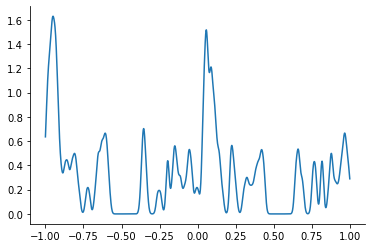

In [190]:
ind = 185
row = hffm.data.iloc[ind]
plt.plot(psth_bins, row['Rc_psth'])
plt.title(row['index'])

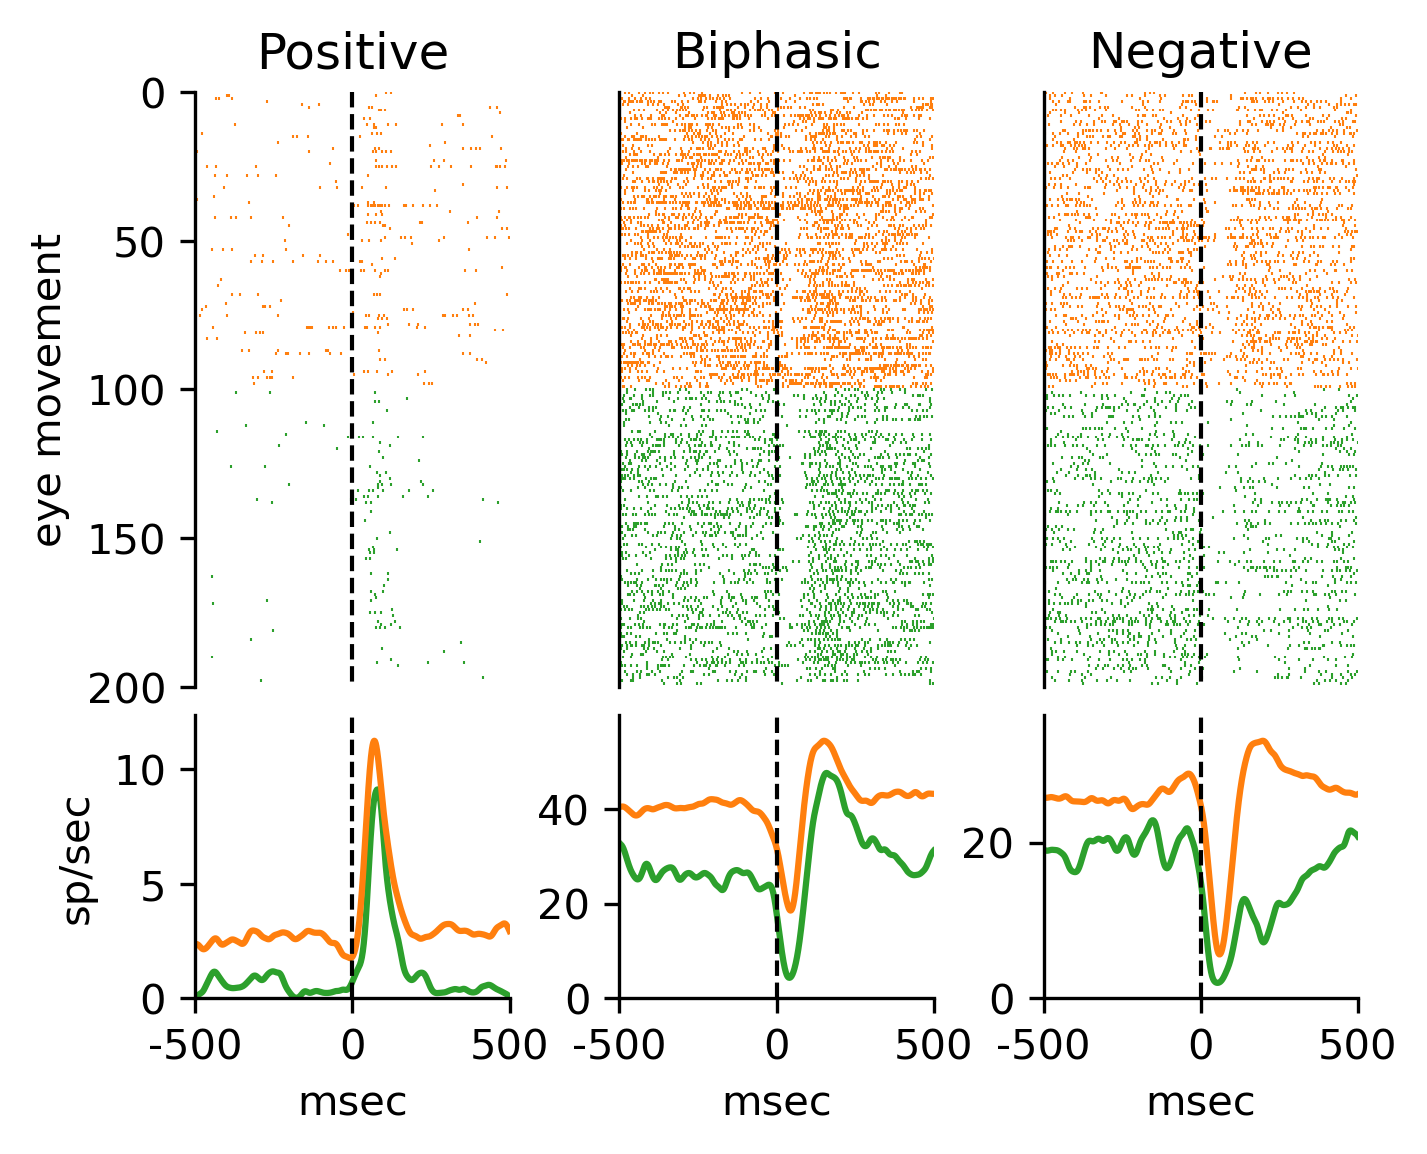

In [174]:
fig4A = plt.figure(constrained_layout=False, figsize=(5,4), dpi=300)
fig4Aspec = gridspec.GridSpec(nrows=3, ncols=3, figure=fig4A, wspace=0.35, hspace=0.1)

ax_pos_raster = fig4A.add_subplot(fig4Aspec[:2,0])
ax_biph_raster = fig4A.add_subplot(fig4Aspec[:2,1])
ax_neg_raster = fig4A.add_subplot(fig4Aspec[:2,2])

ax_pos_psth = fig4A.add_subplot(fig4Aspec[2,0])
ax_biph_psth = fig4A.add_subplot(fig4Aspec[2,1])
ax_neg_psth = fig4A.add_subplot(fig4Aspec[2,2])

num_movements = 100
raster_panels = [ax_pos_raster, ax_biph_raster, ax_neg_raster]
sdf_panels = [ax_pos_psth, ax_biph_psth, ax_neg_psth]
for i, u in enumerate(ex_units):
    row = hffm.data.iloc[u]
    raster_panel = raster_panels[i]
    sdf_panel = sdf_panels[i]
    LR = ex_units_direcprefs[i]

    gazeshifts = row['FmLt_gazeshift_{}_saccTimes_dHead'.format(LR)].copy()
    
    plot_gs = np.random.choice(gazeshifts, size=num_movements, replace=False)
    plot_rc = np.random.choice(eventT.copy(), size=num_movements, replace=False)

    for n, s in enumerate(plot_gs):
        sp = row['FmLt_spikeT']-s
        sp = sp[np.abs(sp)<=0.5]
        raster_panel.vlines(sp, n-0.5, n+0.5, color='tab:orange', linewidth=0.5)

#     for n, s in enumerate(plot_sn):
#         sp = row['Sn_spikeT']-s
#         sp = sp[np.abs(sp)<=0.5]
#         raster_panel.vlines(sp, (num_movements+n)-0.5, (num_movements+n)+0.5, color='tab:green', linewidth=0.5)
        
    for n, s in enumerate(plot_rc):
        sp = row['Rc_spikeT']-s
        sp = sp[np.abs(sp)<=0.5]
        raster_panel.vlines(sp, (num_movements+n)-0.5, (num_movements+n)+0.5, color='tab:green', linewidth=0.5)
    
    height = num_movements*2
    raster_panel.set_ylim([height, 0])
    raster_panel.vlines(0, 0, height, color='k', linewidth=1, linestyle='dashed')
#     raster_panel.set_xlabel('msec')
    if i == 0:
        raster_panel.set_ylabel('eye movement')
    else:
        raster_panel.set_yticks([])
#     raster_panel.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
    raster_panel.set_xticks([])
    raster_panel.set_title(['Positive','Biphasic','Negative'][i])
    raster_panel.set_xlim([-.5,.5])
    raster_panel.axes.spines.bottom.set_visible(False)
    
    sdf_panel.plot(psth_bins, row['Rc_psth'], color='tab:green')
    sdf_panel.plot(psth_bins, row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(LR)], color='tab:orange')
    max_fr = np.nanmax(np.hstack([row['FmLt_gazeshift_{}_saccPSTH_dHead'.format(LR)], row['Rc_psth']]))*1.1
    sdf_panel.set_ylim([0,max_fr])
    sdf_panel.set_xticks(np.linspace(-.5,.5,3), labels=np.linspace(-500,500,3).astype(int))
    sdf_panel.set_xlim([-.5,.5])
    if i == 0:
        sdf_panel.set_ylabel('sp/sec')
#         sdf_panel.annotate('gaze shift', xy=[-.5,14], color='tab:orange')
#         sdf_panel.annotate('compensatory', xy=[-.5,17], color=colors['comp'])
    sdf_panel.set_xlabel('msec')
    sdf_panel.vlines(0, 0, max_fr, color='k', linewidth=1, linestyle='dashed')
    
fig4A.savefig('/home/niell_lab/Desktop/fig4A.pdf')

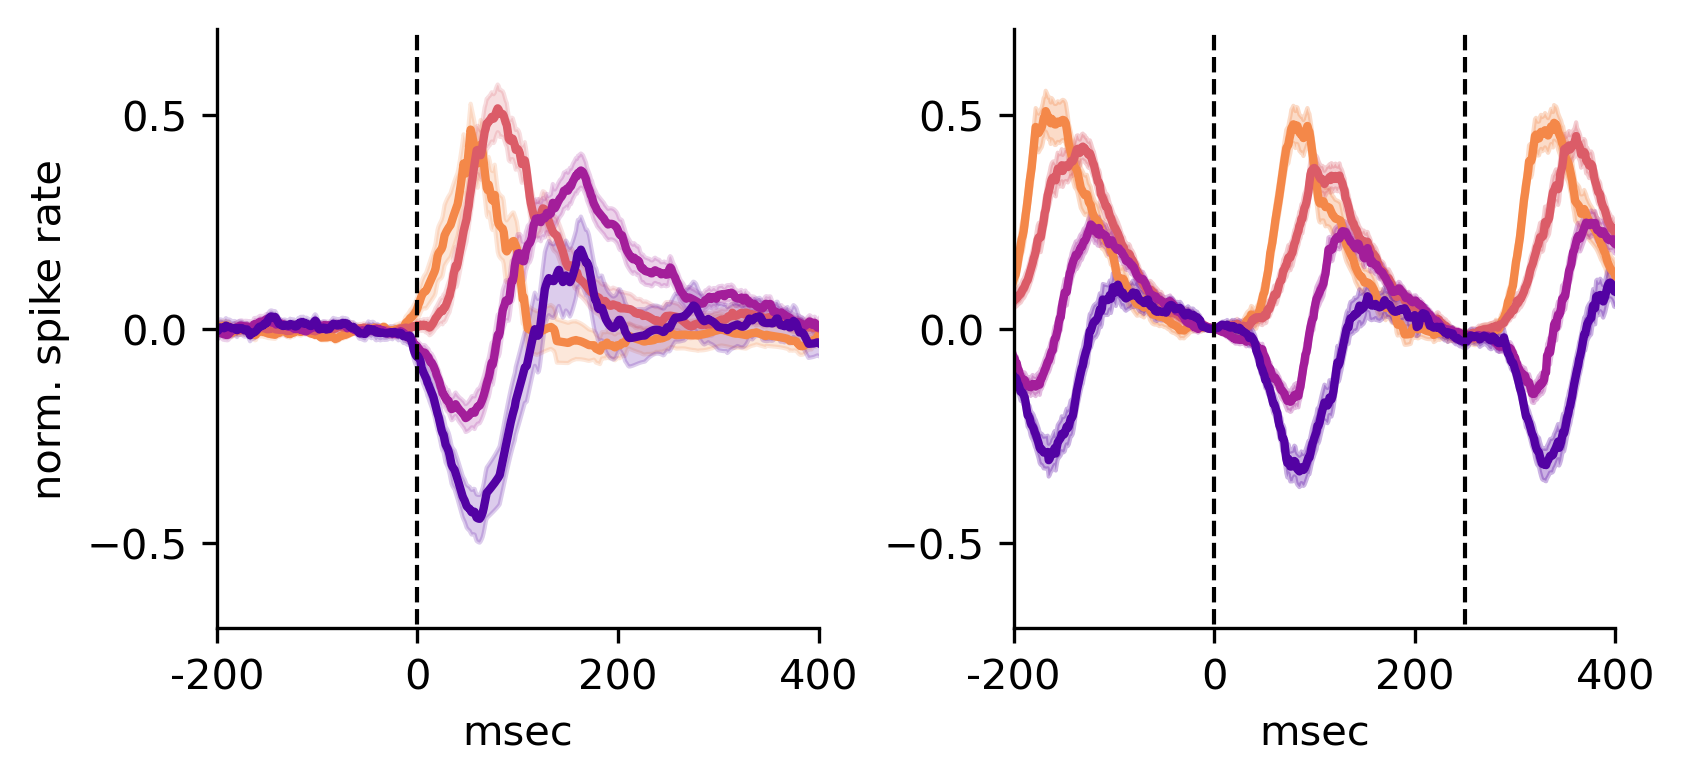

In [173]:
fig4B = plt.figure(constrained_layout=True, figsize=(5.5,2.5), dpi=300)
fig4Bspec = gridspec.GridSpec(nrows=1, ncols=2, figure=fig4B, wspace=0.01, hspace=0)

ax_light_clusters = fig4B.add_subplot(fig4Bspec[:,0])
ax_dark_clusters = fig4B.add_subplot(fig4Bspec[:,1])

step = 0.14
names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    data = hffm.data[hffm.data['movcluster']==name][hffm.data['Rc_rate'].apply(np.mean)>2]
    cluster_psths = flatten_series(data['norm_Rc_psth1'])
    cluster_psths = cluster_psths[~np.isnan(cluster_psths).any(axis=1)]
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_light_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_light_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2) 
ax_light_clusters.set_xlim([-0.2,0.4]); ax_light_clusters.set_ylim([-.7,.7])
# ax_dark_clusters.annotate('early', xy=[0.3,-0.22], color=cat_cmap['early'], fontsize=11)
# ax_dark_clusters.annotate('late', xy=[0.3,-0.22-(step*1)], color=cat_cmap['late'], fontsize=11)
# ax_dark_clusters.annotate('biphasic', xy=[0.3,-0.22-(step*2)], color=cat_cmap['biphasic'], fontsize=11)
# ax_dark_clusters.annotate('negative', xy=[0.3,-0.22-(step*3)], color=cat_cmap['negative'], fontsize=11)
ax_light_clusters.set_ylabel('norm. spike rate'); ax_light_clusters.set_xlabel('msec')
# ax_light_clusters.set_title('Light')
ax_light_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_light_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_light_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

for count, name in enumerate(names):
    data = hffm.data[hffm.data['movcluster']==name]
    cluster_psths = flatten_series(data['norm_Sn_psth1'])
    cluster_psths = cluster_psths[~np.isnan(cluster_psths).any(axis=1)]
    clustmean = np.median(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_dark_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_dark_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.3) 
ax_dark_clusters.set_xlim([-0.2,0.4]); ax_dark_clusters.set_ylim([-.7,.7]); ax_dark_clusters.set_xlabel('msec')
# ax_dark_clusters.set_title('Dark')
ax_dark_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_dark_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_dark_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)
ax_dark_clusters.vlines(.25,-1,1,color='k',linestyle='dashed',linewidth=1)

fig4B.savefig('/home/niell_lab/Desktop/fig4B.pdf')

In [227]:
medians = hffm.data['Rc_rate'].apply(np.mean)

In [234]:
rc_med_bool = (medians>0.01) | (medians<40)
medians = medians[rc_med_bool]

(array([495., 100.,  56.,  31.,  17.,   1.,   8.,   5.,   1.,   2.]),
 array([ 0.        ,  4.58743961,  9.17487923, 13.76231884, 18.34975845,
        22.93719807, 27.52463768, 32.11207729, 36.69951691, 41.28695652,
        45.87439614]),
 <BarContainer object of 10 artists>)

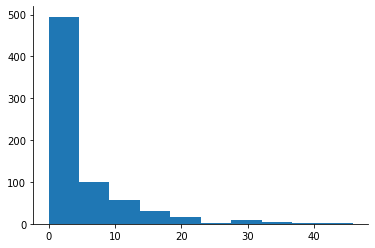

In [233]:
plt.hist(medians)

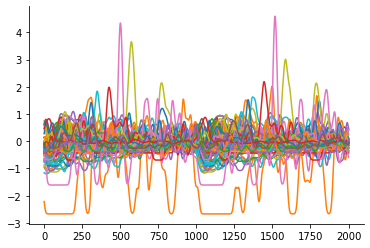

In [222]:
rcplotdata = flatten_series(data['norm_Rc_psth1'][''])
for i in range(np.size(rcplotdata,0)):
    plt.plot(rcplotdata[i,:])

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True,  True, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [201]:
np.isnan(cluster_psths,0)

TypeError: return arrays must be of ArrayType

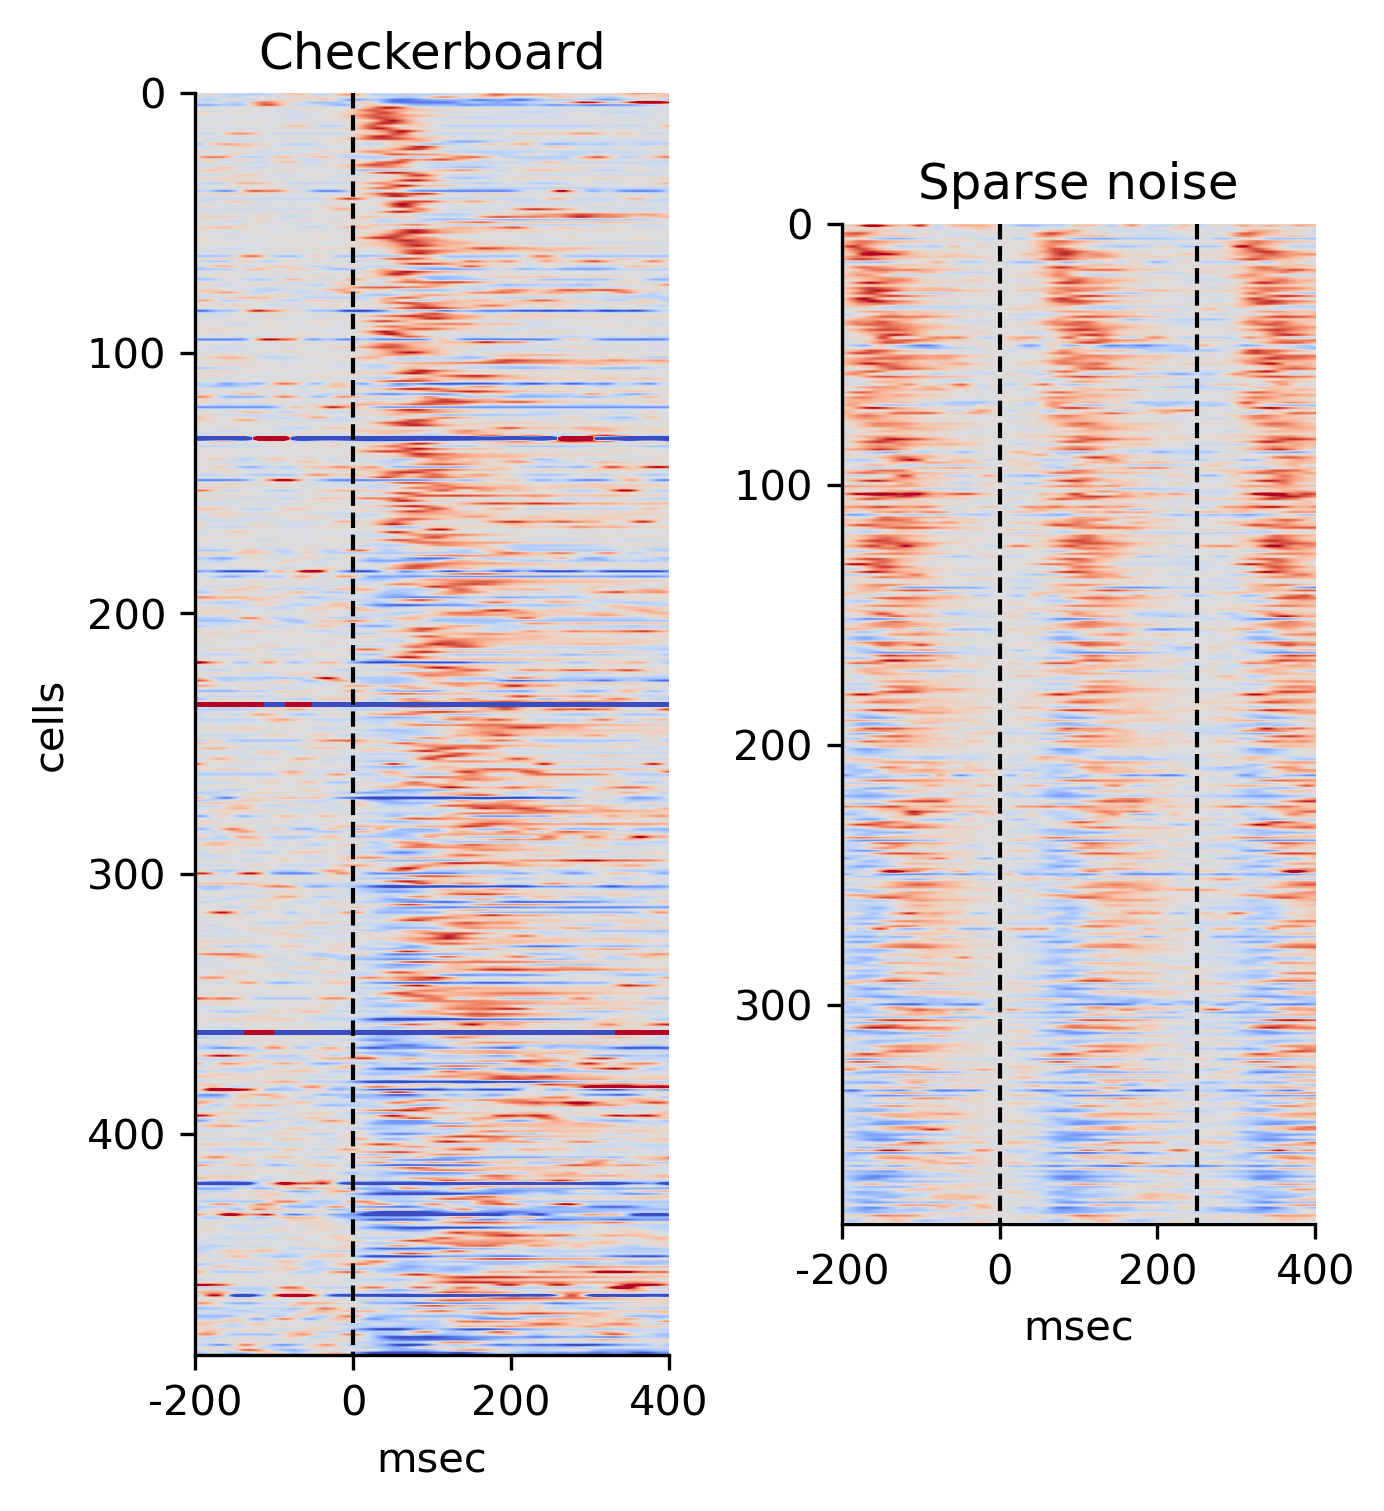

In [153]:
fig3C = plt.figure(constrained_layout=True, figsize=(4.5,6), dpi=300)
fig3Cspec = gridspec.GridSpec(nrows=1, ncols=2, figure=fig3C, wspace=0, hspace=0.5)

ax_tseq_l = fig3C.add_subplot(fig3Cspec[:,0])
ax_tseq_d = fig3C.add_subplot(fig3Cspec[:,1])

tseq_rc = tseq_rc[~np.isnan(tseq_rc).any(axis=1)]
tseq_sn = tseq_sn[~np.isnan(tseq_sn).any(axis=1)]

tseq_aspect = 3.3
plot_tempseq(ax_tseq_l, tseq_rc)
ax_tseq_l.set_aspect(tseq_aspect)
ax_tseq_l.set_title('Checkerboard')
ax_tseq_l.set_ylabel('cells')

plot_tempseq(ax_tseq_d, tseq_sn)
ax_tseq_d.set_aspect(tseq_aspect)
ax_tseq_d.set_title('Sparse noise')
ax_tseq_d.set_yticks(np.arange(0,np.size(tseq_sn,0),100))
ax_tseq_d.vlines(1250, 0, np.size(tseq_sn,0), linestyle='dashed', linewidth=1, color='k')

fig3C.savefig('/home/niell_lab/Desktop/fig4C.pdf')

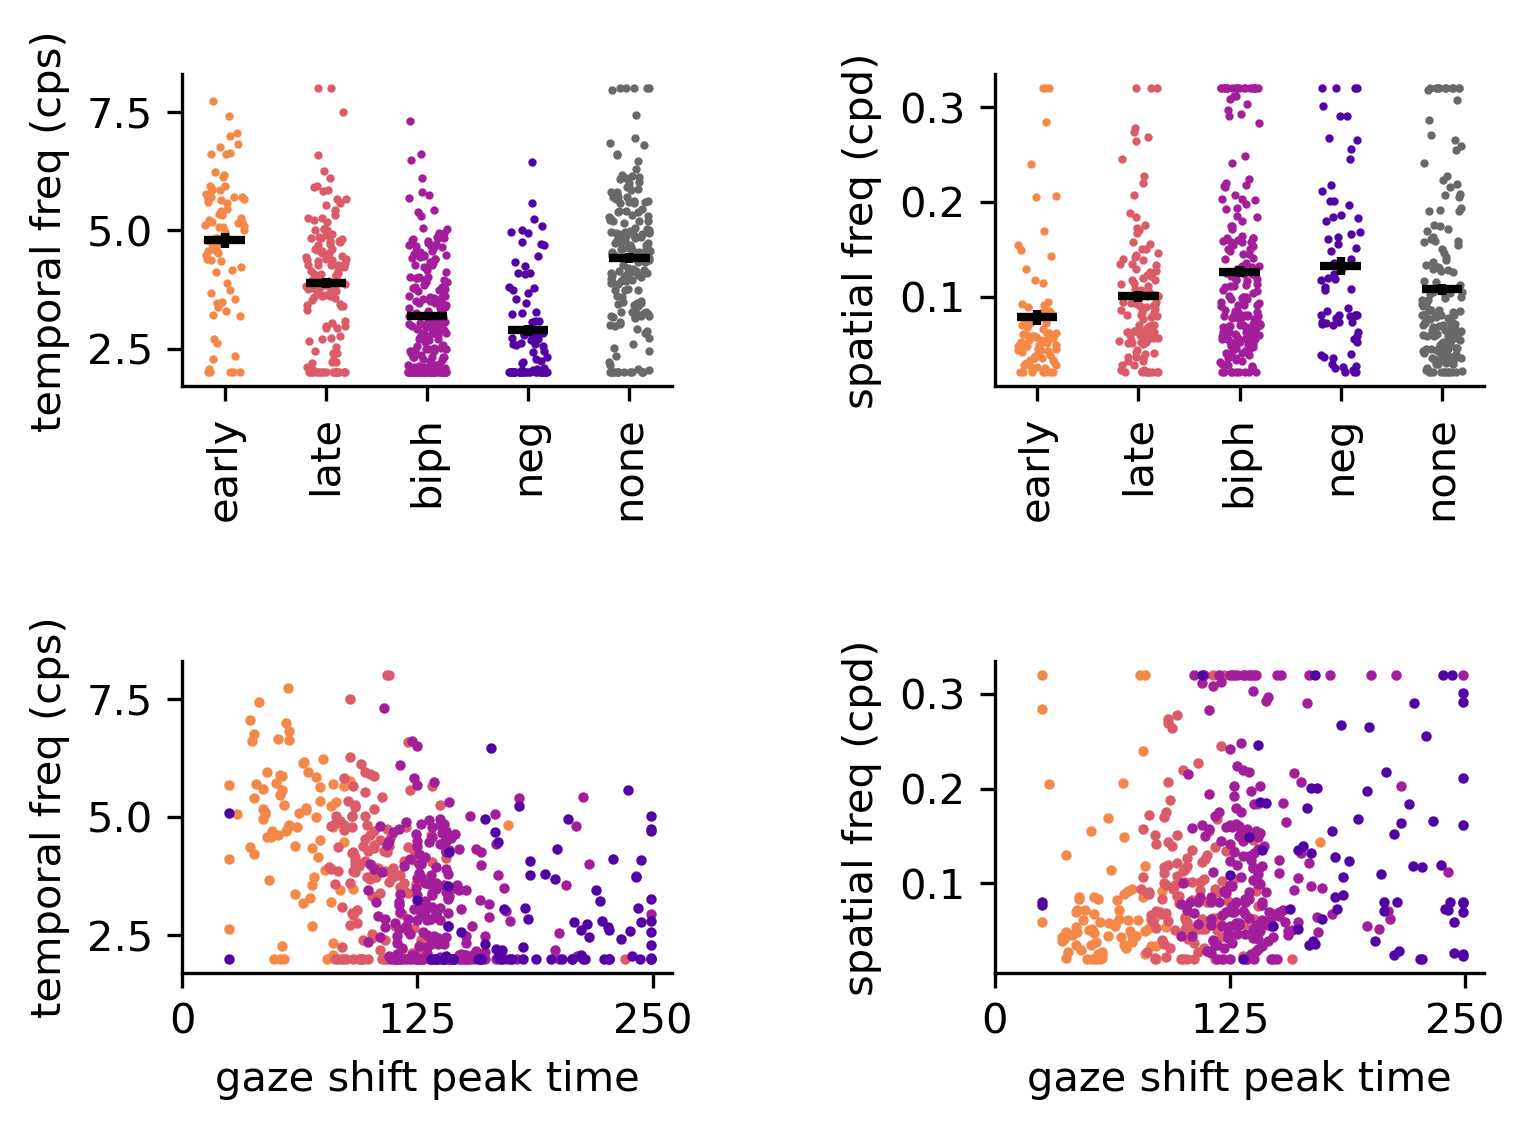

In [176]:
fig5A = plt.figure(constrained_layout=True, figsize=(5,3.5), dpi=300)
fig5Aspec = gridspec.GridSpec(nrows=2, ncols=2, figure=fig5A, wspace=0.2, hspace=0.2)

ax_tf_cat = fig5A.add_subplot(fig5Aspec[0,0])
ax_tf_scatter = fig5A.add_subplot(fig5Aspec[1,0])
ax_sf_cat = fig5A.add_subplot(fig5Aspec[0,1])
ax_sf_scatter = fig5A.add_subplot(fig5Aspec[1,1])

plot_cprop_scatter(ax_tf_cat, 'tf_pref_cps')
ax_tf_cat.set_ylabel('temporal freq (cps)')
ax_tf_cat.set_xticks(range(5), labels=['early','late','biph','neg','none'], rotation=90)

plot_cprop_scatter(ax_sf_cat, 'sf_pref_cpd')
ax_sf_cat.set_ylabel('spatial freq (cpd)')
ax_sf_cat.set_xticks(range(5), labels=['early','late','biph','neg','none'], rotation=90)

for i, name in enumerate(names):
    cluster = hffm.data[hffm.data['movcluster']==name]
    ax_tf_scatter.plot(cluster['psth_peakT'], cluster['tf_pref_cps'], '.', color=cat_cmap[name], markersize=3)
    ax_sf_scatter.plot(cluster['psth_peakT'], cluster['sf_pref_cpd'], '.', color=cat_cmap[name], markersize=3)

ax_tf_scatter.set_xticks(np.linspace(0,0.25,3), labels=np.linspace(0,250,3).astype(int))
ax_tf_scatter.set_xlabel('gaze shift peak time')
ax_tf_scatter.set_ylabel('temporal freq (cps)')

ax_sf_scatter.set_xticks(np.linspace(0,0.25,3), labels=np.linspace(0,250,3).astype(int))
ax_sf_scatter.set_xlabel('gaze shift peak time')
ax_sf_scatter.set_ylabel('spatial freq (cpd)')

fig5A.savefig('/home/niell_lab/Desktop/fig5A.pdf')

In [170]:
for ind, row in hffm.data[hffm.data['responsive_to_gratings']==True].iterrows():
    psth = row['Gt_grating_psth']
    normpsth = (psth - psth[5]) / np.nanmax(psth[5:14].astype(float))
    hffm.data.at[ind, 'norm_grat_psth1'] = normpsth.astype(object)

In [172]:
(~pd.isnull(hffm.data['norm_grat_psth1']))

0      False
1      False
2      False
3      False
4      False
       ...  
711    False
712    False
713    False
714    False
715    False
Name: norm_grat_psth1, Length: 716, dtype: bool

TypeError: object of type 'float' has no len()

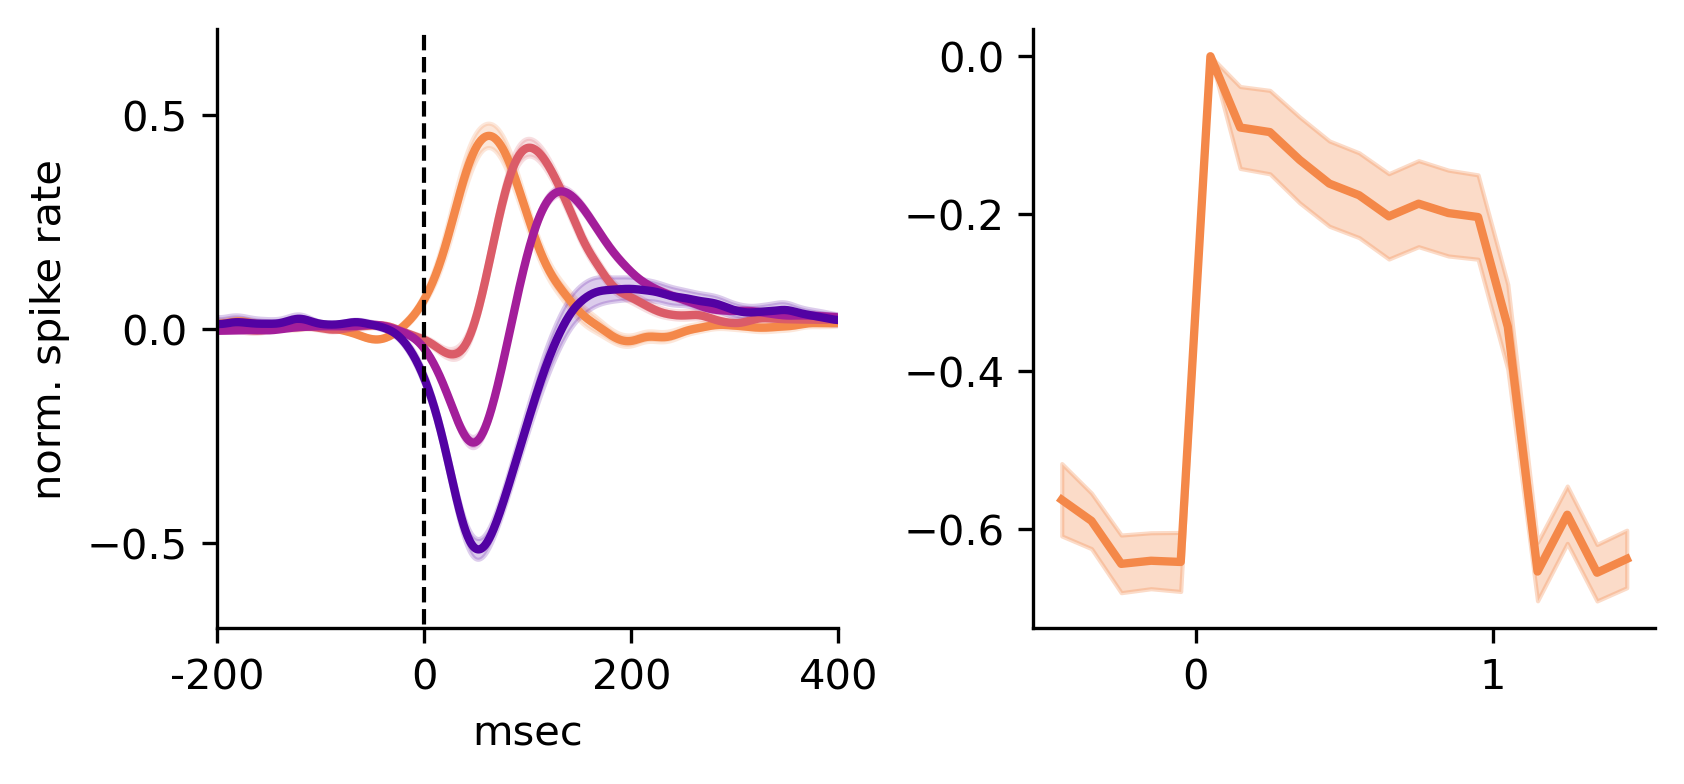

In [304]:
fig4B = plt.figure(constrained_layout=True, figsize=(5.5,2.5), dpi=300)
fig4Bspec = gridspec.GridSpec(nrows=1, ncols=2, figure=fig4B, wspace=0.01, hspace=0)

ax_light_clusters = fig4B.add_subplot(fig4Bspec[:,0])
ax_dark_clusters = fig4B.add_subplot(fig4Bspec[:,1])

step = 0.14
names = ['early','late','biphasic','negative']
for count, name in enumerate(names):
    data = hffm.data[hffm.data['movcluster']==name][hffm.data['Rc_rate'].apply(np.mean)>2]
    cluster_psths = flatten_series(data['pref_gazeshift_psth1'])
    cluster_psths = cluster_psths[~np.isnan(cluster_psths).any(axis=1)]
    clustmean = np.mean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_light_clusters.plot(psth_bins, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_light_clusters.fill_between(psth_bins, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.2) 
ax_light_clusters.set_xlim([-0.2,0.4]); ax_light_clusters.set_ylim([-.7,.7])
# ax_dark_clusters.annotate('early', xy=[0.3,-0.22], color=cat_cmap['early'], fontsize=11)
# ax_dark_clusters.annotate('late', xy=[0.3,-0.22-(step*1)], color=cat_cmap['late'], fontsize=11)
# ax_dark_clusters.annotate('biphasic', xy=[0.3,-0.22-(step*2)], color=cat_cmap['biphasic'], fontsize=11)
# ax_dark_clusters.annotate('negative', xy=[0.3,-0.22-(step*3)], color=cat_cmap['negative'], fontsize=11)
ax_light_clusters.set_ylabel('norm. spike rate'); ax_light_clusters.set_xlabel('msec')
# ax_light_clusters.set_title('Light')
ax_light_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_light_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_light_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

for count, name in enumerate(names):
    data = hffm.data[hffm.data['movcluster']==name]
    cluster_psths = flatten_series(data['norm_grat_psth1'])
    cluster_psths = cluster_psths[~np.isnan(cluster_psths).any(axis=1)]
    clustmean = np.mean(cluster_psths, 0)
    clusterr = np.std(cluster_psths, 0) / np.sqrt(np.size(cluster_psths,0))
    ax_dark_clusters.plot(hffm.grat_psth_x, clustmean, '-', linewidth=2, color=cat_cmap[name])
    ax_dark_clusters.fill_between(hffm.grat_psth_x, clustmean-clusterr, clustmean+clusterr, color=cat_cmap[name], alpha=0.3) 
ax_dark_clusters.set_xlim([-0.2,0.4]); ax_dark_clusters.set_ylim([-.7,.7]); ax_dark_clusters.set_xlabel('msec')
# ax_dark_clusters.set_title('Dark')
ax_dark_clusters.set_xticks(np.linspace(-0.2,0.4,4), labels=np.linspace(-200,400,4).astype(int))
ax_dark_clusters.set_yticks(np.linspace(-0.5,0.5,3))
ax_dark_clusters.vlines(0,-1,1,color='k',linestyle='dashed',linewidth=1)

# fig4B.savefig('/home/niell_lab/Desktop/fig5B.pdf')